<a href="https://colab.research.google.com/github/mrshamshir/Automated-Neurological-Disease-Classification/blob/main/Branch_ResNet_V3(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and data loading

In [ ]:
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path to train datasets and labels

train_rCBF = Path("/content/drive/MyDrive/Assignment/training_images_rcbf.nii")
train_DAT = Path("/content/drive/MyDrive/Assignment/training_images_sbr.nii")

labels = pd.read_csv("/content/drive/MyDrive/Assignment/Diagnoses_of_training_data.csv")

In [ ]:
# Load NIfTI and extract image data
train_PET_rCBF = nib.load(train_rCBF)
train_data_rCBF = train_PET_rCBF.get_fdata()

train_PET_DAT = nib.load(train_DAT)
train_data_DAT = train_PET_DAT.get_fdata()

### Dataset Creation

#### Split data to train, validation, test

In [ ]:
def create_xdata(rCBF, DAT):
    # combine two images of same subjects
    res = np.stack((rCBF, DAT), axis = 3)
    res = np.transpose(res, (4, 3, 0, 1, 2))
    return res

xdata = create_xdata(train_data_rCBF, train_data_DAT)
print(xdata.shape)

(40, 2, 64, 64, 64)


In [ ]:
# Split the dataset into training and validation sets with 80% for training
# 10% for validation, 10% for test, preserving class distribution.

X_train, X_test, y_train, y_test = train_test_split(xdata,
                                                    np.array(labels['diagnose']),
                                                    test_size=0.2, random_state=13,
                                                    stratify=labels['diagnose'])

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5, random_state=13,
                                                    stratify=y_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(32, 2, 64, 64, 64)
(32,)
(4, 2, 64, 64, 64)
(4,)
(4, 2, 64, 64, 64)
(4,)


#### Normalize, augmentation, dataloader

In [ ]:
def calculate_mean_std(data):
    """
        Calculate the mean and standard deviation for each channel across all samples in the input data.

        Args:
        - data (numpy.ndarray): Input data with shape (num_samples, num_channels, depth, height, width).

        Returns:
        - mean (numpy.ndarray): Mean values for each channel across all samples, with shape (num_channels,).
        - std (numpy.ndarray): Standard deviation for each channel across all samples, with shape (num_channels,).
    """
    mean = np.mean(data, axis=(0, 2, 3, 4))
    std = np.std(data, axis=(0, 2, 3, 4))
    return mean, std



mean, std = calculate_mean_std(X_train)
print("Mean for each channel:", mean)
print("Standard deviation for each channel:", std)

Mean for each channel: [12.47252238  2.99483979]
Standard deviation for each channel: [26.93098671 17.29476661]


In [ ]:
# Custom transformation to convert numpy array to tensor
class ToTensor(object):
    def __call__(self, sample):
        return torch.from_numpy(sample).float()  # Convert to float tensor


class Normalize3D(torch.nn.Module):
    def __init__(self, mean, std, inplace=False):
        """
            Initializes the 3D normalization module.

            Args:
            - mean (array-like): Mean values for each channel.
            - std (array-like): Standard deviation values for each channel.
            - inplace (bool): If True, normalize the tensor in-place. Default is False.
        """
        super().__init__()
        self.mean = torch.tensor(mean, dtype=torch.float32).view(-1, 1, 1, 1)
        self.std = torch.tensor(std, dtype=torch.float32).view(-1, 1, 1, 1)
        self.inplace = inplace

    def forward(self, tensor: Tensor) -> Tensor:
        """
            Forward pass of the normalization module.

            Args:
            - tensor (Tensor): Input tensor to be normalized.

            Returns:
            - Tensor: Normalized output tensor.
        """
        if self.inplace:
            tensor.sub_(self.mean).div_(self.std)
            return tensor
        else:
            return (tensor - self.mean) / self.std

    def __repr__(self) -> str:
        """
            Returns a string representation of the normalization module.

            Returns:
            - str: String representation of the module.
        """
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"



In [ ]:
# Define transformations for data augmentation (train) and validation
train_transforms = transforms.Compose([
    ToTensor(),
    Normalize3D(mean, std),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),

])

val_transforms = transforms.Compose([
    ToTensor(),
    Normalize3D(mean, std)
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
            Custom dataset class for handling input data and labels.

            Args:
            - data (array-like): Input data array.
            - labels (array-like): Labels array corresponding to the input data.
            - transform (callable, optional): Optional transform to be applied to the input data.

        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
            Returns the length of the dataset.

            Returns:
            - int: Length of the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
            Retrieves an item from the dataset based on the provided index.

            Args:
            - idx (int): Index of the item to retrieve.

            Returns:
            - dict: A dictionary containing the input data and its corresponding label.
        """
        sample = {'input': self.data[idx], 'label': self.labels[idx] - 1}
        if self.transform:
            sample['input'] = self.transform(sample['input'])
        return sample


In [ ]:
# Create custom datasets with transformations
train_dataset = CustomDataset(X_train, y_train, transform=train_transforms)
val_dataset = CustomDataset(X_val, y_val, transform=val_transforms)  # Apply validation transformation
test_dataset = CustomDataset(X_test, y_test, transform=val_transforms)  # Apply validation transformation

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images and {len(test_dataset)} test images")

There are 32 train images and 4 val images and 4 test images


In [ ]:
print('train dataset', np.unique(train_dataset.labels, return_counts=True))
print('val dataset', np.unique(val_dataset.labels, return_counts=True))
print('test dataset', np.unique(test_dataset.labels, return_counts=True))

train dataset (array([1, 2, 3, 4]), array([8, 8, 8, 8]))
val dataset (array([1, 2, 3, 4]), array([1, 1, 1, 1]))
test dataset (array([1, 2, 3, 4]), array([1, 1, 1, 1]))


In [ ]:
# Define batch size and number of workers
batch_size = 2
num_workers = 0

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Model creation
We use one ResNet for each of images (rCBF and DAT) called ResNetBranch.
For late fusion, we concat features after last layer of ResNet block and then we have 3 fully conncected layers.

In [ ]:
class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetBranch(nn.Module):
    def __init__(self, block, layers, num_channels):
        super(ResNetBranch, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv3d(num_channels, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x


class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=4, zero_init_residual=False):
        super(ResNet3D, self).__init__()
        self.branch1 = ResNetBranch(block, layers, num_channels=1)
        self.branch2 = ResNetBranch(block, layers, num_channels=1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = self.branch1(x[:, 0:1, :, :, :])
        x2 = self.branch2(x[:, 1:2, :, :, :])
        x = torch.cat((x1, x2), dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x


### Train and evaluation

#### Experiment 1:
lr=0.0002 SGD lr_scheduler.CyclicLR

In [ ]:
path_to_save = '/content'

# Initialize the model
model = ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=4)

# Define the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0002, max_lr=0.002,step_size_up=100,mode="exp_range",gamma=0.99)
lrs = []

criterion = nn.CrossEntropyLoss()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_losses = []
validation_losses = []
test_losses=[]

# Training loop
num_epochs = 200  # Adjust the number of epochs as needed
min_val_loss=np.inf
best_val_epoch_num=0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for i, batch in enumerate(tqdm(train_loader)):
        inputs, labels = batch['input'].to(device), batch['label'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

        # Print statistics
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)

    # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['input'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    validation_loss = running_val_loss / len(val_loader)
    validation_losses.append(validation_loss)

    test_correct = 0
    test_total = 0
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch['input'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    test_loss = running_test_loss / len(test_loader)
    test_losses.append(test_loss)

    # Print training loss for the epoch
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {running_val_loss / len(val_loader):.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], test Loss: {running_test_loss / len(test_loader):.4f}")


    print(f"Validation Accuracy for Epoch [{epoch + 1}/{num_epochs}]: {100 * correct / total:.2f}%")
    print(f"Test Accuracy for Epoch [{epoch + 1}/{num_epochs}]: {100 * test_correct / test_total:.2f}%")

    if validation_loss<min_val_loss:
      min_val_loss=validation_loss
      best_val_epoch_num=epoch + 1
      with open(f'{path_to_save}/resnet3d_best.pkl', 'wb') as f:
          pickle.dump(model, f)
      print('best model saved to: ',f'{path_to_save}/resnet3d_best.pkl')


print("-----------------------------------------------------------------")
print("Training finished.")
print(f"Best Val epoch number: {best_val_epoch_num}")

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/200], Training Loss: 1.3809
Epoch [1/200], Validation Loss: 1.3815
Epoch [1/200], test Loss: 1.3808
Validation Accuracy for Epoch [1/200]: 25.00%
Test Accuracy for Epoch [1/200]: 25.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2/200], Training Loss: 1.3383
Epoch [2/200], Validation Loss: 1.3179
Epoch [2/200], test Loss: 1.3303
Validation Accuracy for Epoch [2/200]: 50.00%
Test Accuracy for Epoch [2/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3/200], Training Loss: 1.2875
Epoch [3/200], Validation Loss: 1.0991
Epoch [3/200], test Loss: 1.2260
Validation Accuracy for Epoch [3/200]: 50.00%
Test Accuracy for Epoch [3/200]: 25.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4/200], Training Loss: 1.2396
Epoch [4/200], Validation Loss: 1.0097
Epoch [4/200], test Loss: 1.1594
Validation Accuracy for Epoch [4/200]: 50.00%
Test Accuracy for Epoch [4/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5/200], Training Loss: 1.2584
Epoch [5/200], Validation Loss: 0.9437
Epoch [5/200], test Loss: 1.0407
Validation Accuracy for Epoch [5/200]: 75.00%
Test Accuracy for Epoch [5/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6/200], Training Loss: 1.1687
Epoch [6/200], Validation Loss: 0.8614
Epoch [6/200], test Loss: 0.9933
Validation Accuracy for Epoch [6/200]: 50.00%
Test Accuracy for Epoch [6/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7/200], Training Loss: 1.0790
Epoch [7/200], Validation Loss: 0.8253
Epoch [7/200], test Loss: 0.9772
Validation Accuracy for Epoch [7/200]: 75.00%
Test Accuracy for Epoch [7/200]: 75.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8/200], Training Loss: 1.0644
Epoch [8/200], Validation Loss: 0.7293
Epoch [8/200], test Loss: 0.8594
Validation Accuracy for Epoch [8/200]: 100.00%
Test Accuracy for Epoch [8/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9/200], Training Loss: 1.0297
Epoch [9/200], Validation Loss: 0.7379
Epoch [9/200], test Loss: 0.8207
Validation Accuracy for Epoch [9/200]: 100.00%
Test Accuracy for Epoch [9/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10/200], Training Loss: 0.7587
Epoch [10/200], Validation Loss: 0.6302
Epoch [10/200], test Loss: 0.8687
Validation Accuracy for Epoch [10/200]: 100.00%
Test Accuracy for Epoch [10/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11/200], Training Loss: 0.8791
Epoch [11/200], Validation Loss: 0.5335
Epoch [11/200], test Loss: 0.7314
Validation Accuracy for Epoch [11/200]: 100.00%
Test Accuracy for Epoch [11/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12/200], Training Loss: 0.7787
Epoch [12/200], Validation Loss: 0.6116
Epoch [12/200], test Loss: 0.8570
Validation Accuracy for Epoch [12/200]: 100.00%
Test Accuracy for Epoch [12/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13/200], Training Loss: 0.7100
Epoch [13/200], Validation Loss: 0.5207
Epoch [13/200], test Loss: 0.6469
Validation Accuracy for Epoch [13/200]: 100.00%
Test Accuracy for Epoch [13/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14/200], Training Loss: 0.7076
Epoch [14/200], Validation Loss: 0.5372
Epoch [14/200], test Loss: 0.6892
Validation Accuracy for Epoch [14/200]: 100.00%
Test Accuracy for Epoch [14/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15/200], Training Loss: 0.7955
Epoch [15/200], Validation Loss: 0.5154
Epoch [15/200], test Loss: 0.5916
Validation Accuracy for Epoch [15/200]: 100.00%
Test Accuracy for Epoch [15/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16/200], Training Loss: 0.6217
Epoch [16/200], Validation Loss: 0.4675
Epoch [16/200], test Loss: 0.7635
Validation Accuracy for Epoch [16/200]: 100.00%
Test Accuracy for Epoch [16/200]: 75.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17/200], Training Loss: 0.5073
Epoch [17/200], Validation Loss: 0.4890
Epoch [17/200], test Loss: 0.6127
Validation Accuracy for Epoch [17/200]: 100.00%
Test Accuracy for Epoch [17/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18/200], Training Loss: 0.5284
Epoch [18/200], Validation Loss: 0.4592
Epoch [18/200], test Loss: 0.5566
Validation Accuracy for Epoch [18/200]: 100.00%
Test Accuracy for Epoch [18/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19/200], Training Loss: 0.5412
Epoch [19/200], Validation Loss: 0.3782
Epoch [19/200], test Loss: 0.4638
Validation Accuracy for Epoch [19/200]: 100.00%
Test Accuracy for Epoch [19/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20/200], Training Loss: 0.5165
Epoch [20/200], Validation Loss: 0.3905
Epoch [20/200], test Loss: 0.5363
Validation Accuracy for Epoch [20/200]: 100.00%
Test Accuracy for Epoch [20/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21/200], Training Loss: 0.4865
Epoch [21/200], Validation Loss: 0.5036
Epoch [21/200], test Loss: 0.3330
Validation Accuracy for Epoch [21/200]: 75.00%
Test Accuracy for Epoch [21/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22/200], Training Loss: 0.5399
Epoch [22/200], Validation Loss: 0.3524
Epoch [22/200], test Loss: 0.4852
Validation Accuracy for Epoch [22/200]: 100.00%
Test Accuracy for Epoch [22/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23/200], Training Loss: 0.4279
Epoch [23/200], Validation Loss: 0.6521
Epoch [23/200], test Loss: 0.5420
Validation Accuracy for Epoch [23/200]: 75.00%
Test Accuracy for Epoch [23/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24/200], Training Loss: 0.4923
Epoch [24/200], Validation Loss: 0.2646
Epoch [24/200], test Loss: 0.4396
Validation Accuracy for Epoch [24/200]: 100.00%
Test Accuracy for Epoch [24/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25/200], Training Loss: 0.3930
Epoch [25/200], Validation Loss: 0.3395
Epoch [25/200], test Loss: 0.2955
Validation Accuracy for Epoch [25/200]: 100.00%
Test Accuracy for Epoch [25/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26/200], Training Loss: 0.3374
Epoch [26/200], Validation Loss: 0.2669
Epoch [26/200], test Loss: 0.2316
Validation Accuracy for Epoch [26/200]: 100.00%
Test Accuracy for Epoch [26/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27/200], Training Loss: 0.2312
Epoch [27/200], Validation Loss: 0.2883
Epoch [27/200], test Loss: 0.3243
Validation Accuracy for Epoch [27/200]: 100.00%
Test Accuracy for Epoch [27/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28/200], Training Loss: 0.3785
Epoch [28/200], Validation Loss: 0.2798
Epoch [28/200], test Loss: 0.3864
Validation Accuracy for Epoch [28/200]: 100.00%
Test Accuracy for Epoch [28/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29/200], Training Loss: 0.3606
Epoch [29/200], Validation Loss: 0.4049
Epoch [29/200], test Loss: 0.4513
Validation Accuracy for Epoch [29/200]: 100.00%
Test Accuracy for Epoch [29/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [30/200], Training Loss: 0.3616
Epoch [30/200], Validation Loss: 0.2107
Epoch [30/200], test Loss: 0.3191
Validation Accuracy for Epoch [30/200]: 100.00%
Test Accuracy for Epoch [30/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [31/200], Training Loss: 0.2005
Epoch [31/200], Validation Loss: 0.2317
Epoch [31/200], test Loss: 0.2686
Validation Accuracy for Epoch [31/200]: 100.00%
Test Accuracy for Epoch [31/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [32/200], Training Loss: 0.1740
Epoch [32/200], Validation Loss: 0.3602
Epoch [32/200], test Loss: 0.2439
Validation Accuracy for Epoch [32/200]: 75.00%
Test Accuracy for Epoch [32/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [33/200], Training Loss: 0.3887
Epoch [33/200], Validation Loss: 0.2289
Epoch [33/200], test Loss: 0.2501
Validation Accuracy for Epoch [33/200]: 100.00%
Test Accuracy for Epoch [33/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [34/200], Training Loss: 0.2867
Epoch [34/200], Validation Loss: 0.3398
Epoch [34/200], test Loss: 0.4277
Validation Accuracy for Epoch [34/200]: 100.00%
Test Accuracy for Epoch [34/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [35/200], Training Loss: 0.2952
Epoch [35/200], Validation Loss: 0.2161
Epoch [35/200], test Loss: 0.3384
Validation Accuracy for Epoch [35/200]: 100.00%
Test Accuracy for Epoch [35/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [36/200], Training Loss: 0.1365
Epoch [36/200], Validation Loss: 0.5914
Epoch [36/200], test Loss: 0.3799
Validation Accuracy for Epoch [36/200]: 75.00%
Test Accuracy for Epoch [36/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [37/200], Training Loss: 0.3093
Epoch [37/200], Validation Loss: 0.3637
Epoch [37/200], test Loss: 0.3471
Validation Accuracy for Epoch [37/200]: 75.00%
Test Accuracy for Epoch [37/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [38/200], Training Loss: 0.2052
Epoch [38/200], Validation Loss: 0.4308
Epoch [38/200], test Loss: 0.2648
Validation Accuracy for Epoch [38/200]: 75.00%
Test Accuracy for Epoch [38/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [39/200], Training Loss: 0.2318
Epoch [39/200], Validation Loss: 0.2973
Epoch [39/200], test Loss: 0.3487
Validation Accuracy for Epoch [39/200]: 100.00%
Test Accuracy for Epoch [39/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [40/200], Training Loss: 0.2539
Epoch [40/200], Validation Loss: 1.0728
Epoch [40/200], test Loss: 0.7457
Validation Accuracy for Epoch [40/200]: 75.00%
Test Accuracy for Epoch [40/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [41/200], Training Loss: 0.1525
Epoch [41/200], Validation Loss: 0.5549
Epoch [41/200], test Loss: 0.5989
Validation Accuracy for Epoch [41/200]: 75.00%
Test Accuracy for Epoch [41/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [42/200], Training Loss: 0.2114
Epoch [42/200], Validation Loss: 0.4797
Epoch [42/200], test Loss: 0.3351
Validation Accuracy for Epoch [42/200]: 75.00%
Test Accuracy for Epoch [42/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [43/200], Training Loss: 0.2361
Epoch [43/200], Validation Loss: 0.5074
Epoch [43/200], test Loss: 0.1863
Validation Accuracy for Epoch [43/200]: 75.00%
Test Accuracy for Epoch [43/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [44/200], Training Loss: 0.2236
Epoch [44/200], Validation Loss: 0.5095
Epoch [44/200], test Loss: 0.4465
Validation Accuracy for Epoch [44/200]: 75.00%
Test Accuracy for Epoch [44/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [45/200], Training Loss: 0.1579
Epoch [45/200], Validation Loss: 0.9776
Epoch [45/200], test Loss: 0.5067
Validation Accuracy for Epoch [45/200]: 75.00%
Test Accuracy for Epoch [45/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [46/200], Training Loss: 0.1673
Epoch [46/200], Validation Loss: 0.5087
Epoch [46/200], test Loss: 0.2180
Validation Accuracy for Epoch [46/200]: 75.00%
Test Accuracy for Epoch [46/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [47/200], Training Loss: 0.1380
Epoch [47/200], Validation Loss: 0.5211
Epoch [47/200], test Loss: 0.4735
Validation Accuracy for Epoch [47/200]: 75.00%
Test Accuracy for Epoch [47/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [48/200], Training Loss: 0.2406
Epoch [48/200], Validation Loss: 0.2975
Epoch [48/200], test Loss: 0.1623
Validation Accuracy for Epoch [48/200]: 100.00%
Test Accuracy for Epoch [48/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [49/200], Training Loss: 0.1296
Epoch [49/200], Validation Loss: 0.2870
Epoch [49/200], test Loss: 0.3116
Validation Accuracy for Epoch [49/200]: 100.00%
Test Accuracy for Epoch [49/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [50/200], Training Loss: 0.1601
Epoch [50/200], Validation Loss: 0.1966
Epoch [50/200], test Loss: 0.1365
Validation Accuracy for Epoch [50/200]: 100.00%
Test Accuracy for Epoch [50/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [51/200], Training Loss: 0.0943
Epoch [51/200], Validation Loss: 0.4125
Epoch [51/200], test Loss: 0.2177
Validation Accuracy for Epoch [51/200]: 75.00%
Test Accuracy for Epoch [51/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [52/200], Training Loss: 0.0907
Epoch [52/200], Validation Loss: 0.5726
Epoch [52/200], test Loss: 0.1370
Validation Accuracy for Epoch [52/200]: 75.00%
Test Accuracy for Epoch [52/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [53/200], Training Loss: 0.0530
Epoch [53/200], Validation Loss: 0.5738
Epoch [53/200], test Loss: 0.1408
Validation Accuracy for Epoch [53/200]: 75.00%
Test Accuracy for Epoch [53/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [54/200], Training Loss: 0.0525
Epoch [54/200], Validation Loss: 0.2751
Epoch [54/200], test Loss: 0.1129
Validation Accuracy for Epoch [54/200]: 100.00%
Test Accuracy for Epoch [54/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [55/200], Training Loss: 0.0302
Epoch [55/200], Validation Loss: 0.4072
Epoch [55/200], test Loss: 0.1203
Validation Accuracy for Epoch [55/200]: 75.00%
Test Accuracy for Epoch [55/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [56/200], Training Loss: 0.0431
Epoch [56/200], Validation Loss: 0.3510
Epoch [56/200], test Loss: 0.1723
Validation Accuracy for Epoch [56/200]: 75.00%
Test Accuracy for Epoch [56/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [57/200], Training Loss: 0.0346
Epoch [57/200], Validation Loss: 0.1502
Epoch [57/200], test Loss: 0.1040
Validation Accuracy for Epoch [57/200]: 100.00%
Test Accuracy for Epoch [57/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [58/200], Training Loss: 0.0508
Epoch [58/200], Validation Loss: 0.2025
Epoch [58/200], test Loss: 0.0913
Validation Accuracy for Epoch [58/200]: 100.00%
Test Accuracy for Epoch [58/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [59/200], Training Loss: 0.0247
Epoch [59/200], Validation Loss: 0.1587
Epoch [59/200], test Loss: 0.1342
Validation Accuracy for Epoch [59/200]: 100.00%
Test Accuracy for Epoch [59/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [60/200], Training Loss: 0.0158
Epoch [60/200], Validation Loss: 0.1966
Epoch [60/200], test Loss: 0.1185
Validation Accuracy for Epoch [60/200]: 100.00%
Test Accuracy for Epoch [60/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [61/200], Training Loss: 0.0597
Epoch [61/200], Validation Loss: 0.1926
Epoch [61/200], test Loss: 0.1875
Validation Accuracy for Epoch [61/200]: 100.00%
Test Accuracy for Epoch [61/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [62/200], Training Loss: 0.0308
Epoch [62/200], Validation Loss: 0.2441
Epoch [62/200], test Loss: 0.0971
Validation Accuracy for Epoch [62/200]: 100.00%
Test Accuracy for Epoch [62/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [63/200], Training Loss: 0.0270
Epoch [63/200], Validation Loss: 0.6176
Epoch [63/200], test Loss: 0.2502
Validation Accuracy for Epoch [63/200]: 75.00%
Test Accuracy for Epoch [63/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [64/200], Training Loss: 0.0374
Epoch [64/200], Validation Loss: 0.1935
Epoch [64/200], test Loss: 0.0916
Validation Accuracy for Epoch [64/200]: 100.00%
Test Accuracy for Epoch [64/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [65/200], Training Loss: 0.0178
Epoch [65/200], Validation Loss: 0.2340
Epoch [65/200], test Loss: 0.0603
Validation Accuracy for Epoch [65/200]: 100.00%
Test Accuracy for Epoch [65/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [66/200], Training Loss: 0.0166
Epoch [66/200], Validation Loss: 0.2922
Epoch [66/200], test Loss: 0.0501
Validation Accuracy for Epoch [66/200]: 75.00%
Test Accuracy for Epoch [66/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [67/200], Training Loss: 0.0828
Epoch [67/200], Validation Loss: 0.2449
Epoch [67/200], test Loss: 0.1426
Validation Accuracy for Epoch [67/200]: 75.00%
Test Accuracy for Epoch [67/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [68/200], Training Loss: 0.0564
Epoch [68/200], Validation Loss: 0.5033
Epoch [68/200], test Loss: 0.2848
Validation Accuracy for Epoch [68/200]: 75.00%
Test Accuracy for Epoch [68/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [69/200], Training Loss: 0.0861
Epoch [69/200], Validation Loss: 0.3342
Epoch [69/200], test Loss: 0.0904
Validation Accuracy for Epoch [69/200]: 75.00%
Test Accuracy for Epoch [69/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [70/200], Training Loss: 0.0501
Epoch [70/200], Validation Loss: 0.2760
Epoch [70/200], test Loss: 0.1377
Validation Accuracy for Epoch [70/200]: 100.00%
Test Accuracy for Epoch [70/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [71/200], Training Loss: 0.0417
Epoch [71/200], Validation Loss: 0.2279
Epoch [71/200], test Loss: 0.2077
Validation Accuracy for Epoch [71/200]: 100.00%
Test Accuracy for Epoch [71/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [72/200], Training Loss: 0.0203
Epoch [72/200], Validation Loss: 0.4770
Epoch [72/200], test Loss: 0.1680
Validation Accuracy for Epoch [72/200]: 75.00%
Test Accuracy for Epoch [72/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [73/200], Training Loss: 0.0419
Epoch [73/200], Validation Loss: 0.2652
Epoch [73/200], test Loss: 0.1084
Validation Accuracy for Epoch [73/200]: 100.00%
Test Accuracy for Epoch [73/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [74/200], Training Loss: 0.0245
Epoch [74/200], Validation Loss: 0.3158
Epoch [74/200], test Loss: 0.1132
Validation Accuracy for Epoch [74/200]: 75.00%
Test Accuracy for Epoch [74/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [75/200], Training Loss: 0.0383
Epoch [75/200], Validation Loss: 0.5951
Epoch [75/200], test Loss: 0.1902
Validation Accuracy for Epoch [75/200]: 75.00%
Test Accuracy for Epoch [75/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [76/200], Training Loss: 0.0183
Epoch [76/200], Validation Loss: 0.4316
Epoch [76/200], test Loss: 0.1128
Validation Accuracy for Epoch [76/200]: 75.00%
Test Accuracy for Epoch [76/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [77/200], Training Loss: 0.0333
Epoch [77/200], Validation Loss: 0.2277
Epoch [77/200], test Loss: 0.1339
Validation Accuracy for Epoch [77/200]: 100.00%
Test Accuracy for Epoch [77/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [78/200], Training Loss: 0.0278
Epoch [78/200], Validation Loss: 0.2844
Epoch [78/200], test Loss: 0.0777
Validation Accuracy for Epoch [78/200]: 100.00%
Test Accuracy for Epoch [78/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [79/200], Training Loss: 0.0173
Epoch [79/200], Validation Loss: 0.4181
Epoch [79/200], test Loss: 0.0955
Validation Accuracy for Epoch [79/200]: 75.00%
Test Accuracy for Epoch [79/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [80/200], Training Loss: 0.0323
Epoch [80/200], Validation Loss: 0.4579
Epoch [80/200], test Loss: 0.1099
Validation Accuracy for Epoch [80/200]: 75.00%
Test Accuracy for Epoch [80/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [81/200], Training Loss: 0.0312
Epoch [81/200], Validation Loss: 0.3360
Epoch [81/200], test Loss: 0.4070
Validation Accuracy for Epoch [81/200]: 75.00%
Test Accuracy for Epoch [81/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [82/200], Training Loss: 0.0133
Epoch [82/200], Validation Loss: 0.6639
Epoch [82/200], test Loss: 0.3156
Validation Accuracy for Epoch [82/200]: 75.00%
Test Accuracy for Epoch [82/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [83/200], Training Loss: 0.0179
Epoch [83/200], Validation Loss: 0.8394
Epoch [83/200], test Loss: 0.1729
Validation Accuracy for Epoch [83/200]: 75.00%
Test Accuracy for Epoch [83/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [84/200], Training Loss: 0.0145
Epoch [84/200], Validation Loss: 0.3941
Epoch [84/200], test Loss: 0.1254
Validation Accuracy for Epoch [84/200]: 75.00%
Test Accuracy for Epoch [84/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [85/200], Training Loss: 0.0158
Epoch [85/200], Validation Loss: 0.4098
Epoch [85/200], test Loss: 0.1221
Validation Accuracy for Epoch [85/200]: 75.00%
Test Accuracy for Epoch [85/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [86/200], Training Loss: 0.0089
Epoch [86/200], Validation Loss: 0.4042
Epoch [86/200], test Loss: 0.1170
Validation Accuracy for Epoch [86/200]: 75.00%
Test Accuracy for Epoch [86/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [87/200], Training Loss: 0.0127
Epoch [87/200], Validation Loss: 0.2697
Epoch [87/200], test Loss: 0.1213
Validation Accuracy for Epoch [87/200]: 75.00%
Test Accuracy for Epoch [87/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [88/200], Training Loss: 0.0140
Epoch [88/200], Validation Loss: 0.3191
Epoch [88/200], test Loss: 0.1048
Validation Accuracy for Epoch [88/200]: 75.00%
Test Accuracy for Epoch [88/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [89/200], Training Loss: 0.0115
Epoch [89/200], Validation Loss: 0.4428
Epoch [89/200], test Loss: 0.1090
Validation Accuracy for Epoch [89/200]: 75.00%
Test Accuracy for Epoch [89/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [90/200], Training Loss: 0.0124
Epoch [90/200], Validation Loss: 0.7298
Epoch [90/200], test Loss: 0.1488
Validation Accuracy for Epoch [90/200]: 75.00%
Test Accuracy for Epoch [90/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [91/200], Training Loss: 0.0071
Epoch [91/200], Validation Loss: 0.5810
Epoch [91/200], test Loss: 0.1332
Validation Accuracy for Epoch [91/200]: 75.00%
Test Accuracy for Epoch [91/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [92/200], Training Loss: 0.0160
Epoch [92/200], Validation Loss: 0.5056
Epoch [92/200], test Loss: 0.0963
Validation Accuracy for Epoch [92/200]: 75.00%
Test Accuracy for Epoch [92/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [93/200], Training Loss: 0.0111
Epoch [93/200], Validation Loss: 0.5733
Epoch [93/200], test Loss: 0.1386
Validation Accuracy for Epoch [93/200]: 75.00%
Test Accuracy for Epoch [93/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [94/200], Training Loss: 0.0058
Epoch [94/200], Validation Loss: 0.5444
Epoch [94/200], test Loss: 0.0718
Validation Accuracy for Epoch [94/200]: 75.00%
Test Accuracy for Epoch [94/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [95/200], Training Loss: 0.0131
Epoch [95/200], Validation Loss: 0.4623
Epoch [95/200], test Loss: 0.0935
Validation Accuracy for Epoch [95/200]: 75.00%
Test Accuracy for Epoch [95/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [96/200], Training Loss: 0.0119
Epoch [96/200], Validation Loss: 0.3848
Epoch [96/200], test Loss: 0.0659
Validation Accuracy for Epoch [96/200]: 75.00%
Test Accuracy for Epoch [96/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [97/200], Training Loss: 0.0123
Epoch [97/200], Validation Loss: 0.2628
Epoch [97/200], test Loss: 0.0691
Validation Accuracy for Epoch [97/200]: 100.00%
Test Accuracy for Epoch [97/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [98/200], Training Loss: 0.0117
Epoch [98/200], Validation Loss: 0.3204
Epoch [98/200], test Loss: 0.0678
Validation Accuracy for Epoch [98/200]: 75.00%
Test Accuracy for Epoch [98/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [99/200], Training Loss: 0.0069
Epoch [99/200], Validation Loss: 0.2466
Epoch [99/200], test Loss: 0.0719
Validation Accuracy for Epoch [99/200]: 100.00%
Test Accuracy for Epoch [99/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [100/200], Training Loss: 0.0055
Epoch [100/200], Validation Loss: 0.3552
Epoch [100/200], test Loss: 0.0883
Validation Accuracy for Epoch [100/200]: 75.00%
Test Accuracy for Epoch [100/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [101/200], Training Loss: 0.0032
Epoch [101/200], Validation Loss: 0.3039
Epoch [101/200], test Loss: 0.0841
Validation Accuracy for Epoch [101/200]: 75.00%
Test Accuracy for Epoch [101/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [102/200], Training Loss: 0.0106
Epoch [102/200], Validation Loss: 0.3367
Epoch [102/200], test Loss: 0.0873
Validation Accuracy for Epoch [102/200]: 75.00%
Test Accuracy for Epoch [102/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [103/200], Training Loss: 0.0311
Epoch [103/200], Validation Loss: 0.8164
Epoch [103/200], test Loss: 0.4784
Validation Accuracy for Epoch [103/200]: 75.00%
Test Accuracy for Epoch [103/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [104/200], Training Loss: 0.0210
Epoch [104/200], Validation Loss: 0.2124
Epoch [104/200], test Loss: 0.1964
Validation Accuracy for Epoch [104/200]: 100.00%
Test Accuracy for Epoch [104/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [105/200], Training Loss: 0.0165
Epoch [105/200], Validation Loss: 0.1766
Epoch [105/200], test Loss: 0.3020
Validation Accuracy for Epoch [105/200]: 100.00%
Test Accuracy for Epoch [105/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [106/200], Training Loss: 0.0100
Epoch [106/200], Validation Loss: 0.2287
Epoch [106/200], test Loss: 0.1491
Validation Accuracy for Epoch [106/200]: 100.00%
Test Accuracy for Epoch [106/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [107/200], Training Loss: 0.0389
Epoch [107/200], Validation Loss: 0.6492
Epoch [107/200], test Loss: 0.4958
Validation Accuracy for Epoch [107/200]: 75.00%
Test Accuracy for Epoch [107/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [108/200], Training Loss: 0.0773
Epoch [108/200], Validation Loss: 1.6408
Epoch [108/200], test Loss: 2.3356
Validation Accuracy for Epoch [108/200]: 50.00%
Test Accuracy for Epoch [108/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [109/200], Training Loss: 0.2862
Epoch [109/200], Validation Loss: 0.6234
Epoch [109/200], test Loss: 0.4201
Validation Accuracy for Epoch [109/200]: 50.00%
Test Accuracy for Epoch [109/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [110/200], Training Loss: 0.1374
Epoch [110/200], Validation Loss: 0.4571
Epoch [110/200], test Loss: 0.3064
Validation Accuracy for Epoch [110/200]: 75.00%
Test Accuracy for Epoch [110/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [111/200], Training Loss: 0.1130
Epoch [111/200], Validation Loss: 0.1961
Epoch [111/200], test Loss: 0.3095
Validation Accuracy for Epoch [111/200]: 100.00%
Test Accuracy for Epoch [111/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [112/200], Training Loss: 0.0569
Epoch [112/200], Validation Loss: 0.1926
Epoch [112/200], test Loss: 0.2562
Validation Accuracy for Epoch [112/200]: 100.00%
Test Accuracy for Epoch [112/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [113/200], Training Loss: 0.0588
Epoch [113/200], Validation Loss: 0.4195
Epoch [113/200], test Loss: 0.2863
Validation Accuracy for Epoch [113/200]: 75.00%
Test Accuracy for Epoch [113/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [114/200], Training Loss: 0.0287
Epoch [114/200], Validation Loss: 0.2271
Epoch [114/200], test Loss: 0.1070
Validation Accuracy for Epoch [114/200]: 100.00%
Test Accuracy for Epoch [114/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [115/200], Training Loss: 0.0221
Epoch [115/200], Validation Loss: 0.1981
Epoch [115/200], test Loss: 0.1112
Validation Accuracy for Epoch [115/200]: 100.00%
Test Accuracy for Epoch [115/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [116/200], Training Loss: 0.0460
Epoch [116/200], Validation Loss: 0.1962
Epoch [116/200], test Loss: 0.1373
Validation Accuracy for Epoch [116/200]: 100.00%
Test Accuracy for Epoch [116/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [117/200], Training Loss: 0.0250
Epoch [117/200], Validation Loss: 0.1843
Epoch [117/200], test Loss: 0.0908
Validation Accuracy for Epoch [117/200]: 100.00%
Test Accuracy for Epoch [117/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [118/200], Training Loss: 0.0075
Epoch [118/200], Validation Loss: 0.1912
Epoch [118/200], test Loss: 0.0586
Validation Accuracy for Epoch [118/200]: 100.00%
Test Accuracy for Epoch [118/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [119/200], Training Loss: 0.0137
Epoch [119/200], Validation Loss: 0.1299
Epoch [119/200], test Loss: 0.0480
Validation Accuracy for Epoch [119/200]: 100.00%
Test Accuracy for Epoch [119/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [120/200], Training Loss: 0.0145
Epoch [120/200], Validation Loss: 0.3322
Epoch [120/200], test Loss: 0.0993
Validation Accuracy for Epoch [120/200]: 75.00%
Test Accuracy for Epoch [120/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [121/200], Training Loss: 0.0053
Epoch [121/200], Validation Loss: 0.3726
Epoch [121/200], test Loss: 0.1316
Validation Accuracy for Epoch [121/200]: 75.00%
Test Accuracy for Epoch [121/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [122/200], Training Loss: 0.0160
Epoch [122/200], Validation Loss: 0.3186
Epoch [122/200], test Loss: 0.0673
Validation Accuracy for Epoch [122/200]: 75.00%
Test Accuracy for Epoch [122/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [123/200], Training Loss: 0.0167
Epoch [123/200], Validation Loss: 0.1322
Epoch [123/200], test Loss: 0.0883
Validation Accuracy for Epoch [123/200]: 100.00%
Test Accuracy for Epoch [123/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [124/200], Training Loss: 0.0152
Epoch [124/200], Validation Loss: 0.2355
Epoch [124/200], test Loss: 0.1304
Validation Accuracy for Epoch [124/200]: 75.00%
Test Accuracy for Epoch [124/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [125/200], Training Loss: 0.0181
Epoch [125/200], Validation Loss: 0.2395
Epoch [125/200], test Loss: 0.0648
Validation Accuracy for Epoch [125/200]: 75.00%
Test Accuracy for Epoch [125/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [126/200], Training Loss: 0.0101
Epoch [126/200], Validation Loss: 0.1453
Epoch [126/200], test Loss: 0.0777
Validation Accuracy for Epoch [126/200]: 100.00%
Test Accuracy for Epoch [126/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [127/200], Training Loss: 0.0093
Epoch [127/200], Validation Loss: 0.2482
Epoch [127/200], test Loss: 0.0723
Validation Accuracy for Epoch [127/200]: 100.00%
Test Accuracy for Epoch [127/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [128/200], Training Loss: 0.0075
Epoch [128/200], Validation Loss: 0.2887
Epoch [128/200], test Loss: 0.1181
Validation Accuracy for Epoch [128/200]: 75.00%
Test Accuracy for Epoch [128/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [129/200], Training Loss: 0.0044
Epoch [129/200], Validation Loss: 0.2491
Epoch [129/200], test Loss: 0.1047
Validation Accuracy for Epoch [129/200]: 75.00%
Test Accuracy for Epoch [129/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [130/200], Training Loss: 0.0069
Epoch [130/200], Validation Loss: 0.2060
Epoch [130/200], test Loss: 0.0879
Validation Accuracy for Epoch [130/200]: 100.00%
Test Accuracy for Epoch [130/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [131/200], Training Loss: 0.0085
Epoch [131/200], Validation Loss: 0.2149
Epoch [131/200], test Loss: 0.1099
Validation Accuracy for Epoch [131/200]: 100.00%
Test Accuracy for Epoch [131/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [132/200], Training Loss: 0.0059
Epoch [132/200], Validation Loss: 0.1914
Epoch [132/200], test Loss: 0.0699
Validation Accuracy for Epoch [132/200]: 100.00%
Test Accuracy for Epoch [132/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [133/200], Training Loss: 0.0110
Epoch [133/200], Validation Loss: 0.1925
Epoch [133/200], test Loss: 0.0630
Validation Accuracy for Epoch [133/200]: 100.00%
Test Accuracy for Epoch [133/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [134/200], Training Loss: 0.0070
Epoch [134/200], Validation Loss: 0.2193
Epoch [134/200], test Loss: 0.0694
Validation Accuracy for Epoch [134/200]: 100.00%
Test Accuracy for Epoch [134/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [135/200], Training Loss: 0.0073
Epoch [135/200], Validation Loss: 0.1740
Epoch [135/200], test Loss: 0.0965
Validation Accuracy for Epoch [135/200]: 100.00%
Test Accuracy for Epoch [135/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [136/200], Training Loss: 0.0117
Epoch [136/200], Validation Loss: 0.4743
Epoch [136/200], test Loss: 0.1201
Validation Accuracy for Epoch [136/200]: 75.00%
Test Accuracy for Epoch [136/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [137/200], Training Loss: 0.0081
Epoch [137/200], Validation Loss: 0.3550
Epoch [137/200], test Loss: 0.1220
Validation Accuracy for Epoch [137/200]: 75.00%
Test Accuracy for Epoch [137/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [138/200], Training Loss: 0.0053
Epoch [138/200], Validation Loss: 0.3352
Epoch [138/200], test Loss: 0.0896
Validation Accuracy for Epoch [138/200]: 75.00%
Test Accuracy for Epoch [138/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [139/200], Training Loss: 0.0042
Epoch [139/200], Validation Loss: 0.3286
Epoch [139/200], test Loss: 0.1239
Validation Accuracy for Epoch [139/200]: 75.00%
Test Accuracy for Epoch [139/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [140/200], Training Loss: 0.0025
Epoch [140/200], Validation Loss: 0.2533
Epoch [140/200], test Loss: 0.0890
Validation Accuracy for Epoch [140/200]: 75.00%
Test Accuracy for Epoch [140/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [141/200], Training Loss: 0.0083
Epoch [141/200], Validation Loss: 0.2318
Epoch [141/200], test Loss: 0.0758
Validation Accuracy for Epoch [141/200]: 75.00%
Test Accuracy for Epoch [141/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [142/200], Training Loss: 0.0062
Epoch [142/200], Validation Loss: 0.1507
Epoch [142/200], test Loss: 0.0662
Validation Accuracy for Epoch [142/200]: 100.00%
Test Accuracy for Epoch [142/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [143/200], Training Loss: 0.0089
Epoch [143/200], Validation Loss: 0.1339
Epoch [143/200], test Loss: 0.1009
Validation Accuracy for Epoch [143/200]: 100.00%
Test Accuracy for Epoch [143/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [144/200], Training Loss: 0.0052
Epoch [144/200], Validation Loss: 0.1229
Epoch [144/200], test Loss: 0.0613
Validation Accuracy for Epoch [144/200]: 100.00%
Test Accuracy for Epoch [144/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [145/200], Training Loss: 0.0055
Epoch [145/200], Validation Loss: 0.1313
Epoch [145/200], test Loss: 0.0991
Validation Accuracy for Epoch [145/200]: 100.00%
Test Accuracy for Epoch [145/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [146/200], Training Loss: 0.0058
Epoch [146/200], Validation Loss: 0.1265
Epoch [146/200], test Loss: 0.0572
Validation Accuracy for Epoch [146/200]: 100.00%
Test Accuracy for Epoch [146/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [147/200], Training Loss: 0.0061
Epoch [147/200], Validation Loss: 0.1394
Epoch [147/200], test Loss: 0.0718
Validation Accuracy for Epoch [147/200]: 100.00%
Test Accuracy for Epoch [147/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [148/200], Training Loss: 0.0065
Epoch [148/200], Validation Loss: 0.1704
Epoch [148/200], test Loss: 0.0482
Validation Accuracy for Epoch [148/200]: 100.00%
Test Accuracy for Epoch [148/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [149/200], Training Loss: 0.0041
Epoch [149/200], Validation Loss: 0.1689
Epoch [149/200], test Loss: 0.0744
Validation Accuracy for Epoch [149/200]: 100.00%
Test Accuracy for Epoch [149/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [150/200], Training Loss: 0.0055
Epoch [150/200], Validation Loss: 0.1775
Epoch [150/200], test Loss: 0.0916
Validation Accuracy for Epoch [150/200]: 100.00%
Test Accuracy for Epoch [150/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [151/200], Training Loss: 0.0039
Epoch [151/200], Validation Loss: 0.1665
Epoch [151/200], test Loss: 0.0497
Validation Accuracy for Epoch [151/200]: 100.00%
Test Accuracy for Epoch [151/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [152/200], Training Loss: 0.0066
Epoch [152/200], Validation Loss: 0.1996
Epoch [152/200], test Loss: 0.0612
Validation Accuracy for Epoch [152/200]: 100.00%
Test Accuracy for Epoch [152/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [153/200], Training Loss: 0.0044
Epoch [153/200], Validation Loss: 0.2154
Epoch [153/200], test Loss: 0.0702
Validation Accuracy for Epoch [153/200]: 75.00%
Test Accuracy for Epoch [153/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [154/200], Training Loss: 0.0037
Epoch [154/200], Validation Loss: 0.2390
Epoch [154/200], test Loss: 0.0802
Validation Accuracy for Epoch [154/200]: 75.00%
Test Accuracy for Epoch [154/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [155/200], Training Loss: 0.0092
Epoch [155/200], Validation Loss: 0.2257
Epoch [155/200], test Loss: 0.0600
Validation Accuracy for Epoch [155/200]: 75.00%
Test Accuracy for Epoch [155/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [156/200], Training Loss: 0.0058
Epoch [156/200], Validation Loss: 0.2084
Epoch [156/200], test Loss: 0.0833
Validation Accuracy for Epoch [156/200]: 100.00%
Test Accuracy for Epoch [156/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [157/200], Training Loss: 0.0042
Epoch [157/200], Validation Loss: 0.1934
Epoch [157/200], test Loss: 0.0645
Validation Accuracy for Epoch [157/200]: 100.00%
Test Accuracy for Epoch [157/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [158/200], Training Loss: 0.0036
Epoch [158/200], Validation Loss: 0.2178
Epoch [158/200], test Loss: 0.0846
Validation Accuracy for Epoch [158/200]: 75.00%
Test Accuracy for Epoch [158/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [159/200], Training Loss: 0.0058
Epoch [159/200], Validation Loss: 0.2120
Epoch [159/200], test Loss: 0.0902
Validation Accuracy for Epoch [159/200]: 75.00%
Test Accuracy for Epoch [159/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [160/200], Training Loss: 0.0042
Epoch [160/200], Validation Loss: 0.1735
Epoch [160/200], test Loss: 0.1094
Validation Accuracy for Epoch [160/200]: 100.00%
Test Accuracy for Epoch [160/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [161/200], Training Loss: 0.0018
Epoch [161/200], Validation Loss: 0.2007
Epoch [161/200], test Loss: 0.0723
Validation Accuracy for Epoch [161/200]: 100.00%
Test Accuracy for Epoch [161/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [162/200], Training Loss: 0.0048
Epoch [162/200], Validation Loss: 0.1675
Epoch [162/200], test Loss: 0.0935
Validation Accuracy for Epoch [162/200]: 100.00%
Test Accuracy for Epoch [162/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [163/200], Training Loss: 0.0017
Epoch [163/200], Validation Loss: 0.1332
Epoch [163/200], test Loss: 0.0734
Validation Accuracy for Epoch [163/200]: 100.00%
Test Accuracy for Epoch [163/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [164/200], Training Loss: 0.0034
Epoch [164/200], Validation Loss: 0.1467
Epoch [164/200], test Loss: 0.0731
Validation Accuracy for Epoch [164/200]: 100.00%
Test Accuracy for Epoch [164/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [165/200], Training Loss: 0.0053
Epoch [165/200], Validation Loss: 0.1174
Epoch [165/200], test Loss: 0.0688
Validation Accuracy for Epoch [165/200]: 100.00%
Test Accuracy for Epoch [165/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [166/200], Training Loss: 0.0035
Epoch [166/200], Validation Loss: 0.1893
Epoch [166/200], test Loss: 0.0784
Validation Accuracy for Epoch [166/200]: 100.00%
Test Accuracy for Epoch [166/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [167/200], Training Loss: 0.0020
Epoch [167/200], Validation Loss: 0.2309
Epoch [167/200], test Loss: 0.0889
Validation Accuracy for Epoch [167/200]: 75.00%
Test Accuracy for Epoch [167/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [168/200], Training Loss: 0.0059
Epoch [168/200], Validation Loss: 0.1679
Epoch [168/200], test Loss: 0.0858
Validation Accuracy for Epoch [168/200]: 100.00%
Test Accuracy for Epoch [168/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [169/200], Training Loss: 0.0030
Epoch [169/200], Validation Loss: 0.2316
Epoch [169/200], test Loss: 0.1443
Validation Accuracy for Epoch [169/200]: 75.00%
Test Accuracy for Epoch [169/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [170/200], Training Loss: 0.0072
Epoch [170/200], Validation Loss: 0.1680
Epoch [170/200], test Loss: 0.0613
Validation Accuracy for Epoch [170/200]: 100.00%
Test Accuracy for Epoch [170/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [171/200], Training Loss: 0.0027
Epoch [171/200], Validation Loss: 0.2126
Epoch [171/200], test Loss: 0.0522
Validation Accuracy for Epoch [171/200]: 100.00%
Test Accuracy for Epoch [171/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [172/200], Training Loss: 0.0017
Epoch [172/200], Validation Loss: 0.1954
Epoch [172/200], test Loss: 0.0514
Validation Accuracy for Epoch [172/200]: 100.00%
Test Accuracy for Epoch [172/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [173/200], Training Loss: 0.0076
Epoch [173/200], Validation Loss: 0.1602
Epoch [173/200], test Loss: 0.0700
Validation Accuracy for Epoch [173/200]: 100.00%
Test Accuracy for Epoch [173/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [174/200], Training Loss: 0.0023
Epoch [174/200], Validation Loss: 0.1211
Epoch [174/200], test Loss: 0.0715
Validation Accuracy for Epoch [174/200]: 100.00%
Test Accuracy for Epoch [174/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [175/200], Training Loss: 0.0041
Epoch [175/200], Validation Loss: 0.1213
Epoch [175/200], test Loss: 0.0610
Validation Accuracy for Epoch [175/200]: 100.00%
Test Accuracy for Epoch [175/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [176/200], Training Loss: 0.0055
Epoch [176/200], Validation Loss: 0.1312
Epoch [176/200], test Loss: 0.0546
Validation Accuracy for Epoch [176/200]: 100.00%
Test Accuracy for Epoch [176/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [177/200], Training Loss: 0.0029
Epoch [177/200], Validation Loss: 0.1261
Epoch [177/200], test Loss: 0.0731
Validation Accuracy for Epoch [177/200]: 100.00%
Test Accuracy for Epoch [177/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [178/200], Training Loss: 0.0049
Epoch [178/200], Validation Loss: 0.2217
Epoch [178/200], test Loss: 0.0744
Validation Accuracy for Epoch [178/200]: 75.00%
Test Accuracy for Epoch [178/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [179/200], Training Loss: 0.0045
Epoch [179/200], Validation Loss: 0.1872
Epoch [179/200], test Loss: 0.0899
Validation Accuracy for Epoch [179/200]: 100.00%
Test Accuracy for Epoch [179/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [180/200], Training Loss: 0.0027
Epoch [180/200], Validation Loss: 0.1992
Epoch [180/200], test Loss: 0.0739
Validation Accuracy for Epoch [180/200]: 100.00%
Test Accuracy for Epoch [180/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [181/200], Training Loss: 0.0012
Epoch [181/200], Validation Loss: 0.1797
Epoch [181/200], test Loss: 0.0711
Validation Accuracy for Epoch [181/200]: 100.00%
Test Accuracy for Epoch [181/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [182/200], Training Loss: 0.0022
Epoch [182/200], Validation Loss: 0.2115
Epoch [182/200], test Loss: 0.0600
Validation Accuracy for Epoch [182/200]: 100.00%
Test Accuracy for Epoch [182/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [183/200], Training Loss: 0.0050
Epoch [183/200], Validation Loss: 0.2053
Epoch [183/200], test Loss: 0.0638
Validation Accuracy for Epoch [183/200]: 100.00%
Test Accuracy for Epoch [183/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [184/200], Training Loss: 0.0021
Epoch [184/200], Validation Loss: 0.1342
Epoch [184/200], test Loss: 0.0874
Validation Accuracy for Epoch [184/200]: 100.00%
Test Accuracy for Epoch [184/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [185/200], Training Loss: 0.0019
Epoch [185/200], Validation Loss: 0.1109
Epoch [185/200], test Loss: 0.0774
Validation Accuracy for Epoch [185/200]: 100.00%
Test Accuracy for Epoch [185/200]: 100.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [186/200], Training Loss: 0.0060
Epoch [186/200], Validation Loss: 0.1635
Epoch [186/200], test Loss: 0.0694
Validation Accuracy for Epoch [186/200]: 100.00%
Test Accuracy for Epoch [186/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [187/200], Training Loss: 0.0030
Epoch [187/200], Validation Loss: 0.1539
Epoch [187/200], test Loss: 0.0714
Validation Accuracy for Epoch [187/200]: 100.00%
Test Accuracy for Epoch [187/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [188/200], Training Loss: 0.0012
Epoch [188/200], Validation Loss: 0.1696
Epoch [188/200], test Loss: 0.0879
Validation Accuracy for Epoch [188/200]: 100.00%
Test Accuracy for Epoch [188/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [189/200], Training Loss: 0.0046
Epoch [189/200], Validation Loss: 0.1692
Epoch [189/200], test Loss: 0.0647
Validation Accuracy for Epoch [189/200]: 100.00%
Test Accuracy for Epoch [189/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [190/200], Training Loss: 0.0036
Epoch [190/200], Validation Loss: 0.1931
Epoch [190/200], test Loss: 0.1108
Validation Accuracy for Epoch [190/200]: 100.00%
Test Accuracy for Epoch [190/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [191/200], Training Loss: 0.0036
Epoch [191/200], Validation Loss: 0.1784
Epoch [191/200], test Loss: 0.0820
Validation Accuracy for Epoch [191/200]: 100.00%
Test Accuracy for Epoch [191/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [192/200], Training Loss: 0.0061
Epoch [192/200], Validation Loss: 0.2619
Epoch [192/200], test Loss: 0.0700
Validation Accuracy for Epoch [192/200]: 75.00%
Test Accuracy for Epoch [192/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [193/200], Training Loss: 0.0017
Epoch [193/200], Validation Loss: 0.2076
Epoch [193/200], test Loss: 0.0581
Validation Accuracy for Epoch [193/200]: 100.00%
Test Accuracy for Epoch [193/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [194/200], Training Loss: 0.0036
Epoch [194/200], Validation Loss: 0.2342
Epoch [194/200], test Loss: 0.0796
Validation Accuracy for Epoch [194/200]: 75.00%
Test Accuracy for Epoch [194/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [195/200], Training Loss: 0.0043
Epoch [195/200], Validation Loss: 0.2205
Epoch [195/200], test Loss: 0.0456
Validation Accuracy for Epoch [195/200]: 100.00%
Test Accuracy for Epoch [195/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [196/200], Training Loss: 0.0043
Epoch [196/200], Validation Loss: 0.2121
Epoch [196/200], test Loss: 0.0792
Validation Accuracy for Epoch [196/200]: 75.00%
Test Accuracy for Epoch [196/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [197/200], Training Loss: 0.0024
Epoch [197/200], Validation Loss: 0.2045
Epoch [197/200], test Loss: 0.0638
Validation Accuracy for Epoch [197/200]: 100.00%
Test Accuracy for Epoch [197/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [198/200], Training Loss: 0.0025
Epoch [198/200], Validation Loss: 0.2649
Epoch [198/200], test Loss: 0.0826
Validation Accuracy for Epoch [198/200]: 75.00%
Test Accuracy for Epoch [198/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [199/200], Training Loss: 0.0028
Epoch [199/200], Validation Loss: 0.2532
Epoch [199/200], test Loss: 0.0799
Validation Accuracy for Epoch [199/200]: 75.00%
Test Accuracy for Epoch [199/200]: 100.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [200/200], Training Loss: 0.0032
Epoch [200/200], Validation Loss: 0.2270
Epoch [200/200], test Loss: 0.0648
Validation Accuracy for Epoch [200/200]: 75.00%
Test Accuracy for Epoch [200/200]: 100.00%
-----------------------------------------------------------------
Training finished.
Best Val epoch number: 185


In [ ]:
def load_model(model_path):
    """
        Load a model from a specified path using pickle.

        Args:
        - model_path (str): Path to the saved model file.

        Returns:
        - model: Loaded model object.
    """
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

model_path="/content/drive/MyDrive/output/ML_Task/resnet3d_best_0.0002_SGD_best_on_min_val_loss.pkl"

loaded_model = load_model(model_path)

In [ ]:
loaded_model.eval()  # Set model to evaluation mode
test_correct = 0
test_total = 0
running_test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['input'].to(device), batch['label'].to(device)
        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
test_loss = running_test_loss / len(test_loader)
# test_losses.append(test_loss)


# Print training loss for the epoch
if (epoch + 1) % 1 == 0:
    print(f"Best model test Loss: {running_test_loss / len(test_loader):.4f}")

print(f"Test Accuracy for best model on val loss: {100 * test_correct / test_total:.2f}%")

Best model test Loss: 0.0774
Test Accuracy for best model on val loss: 100.00%


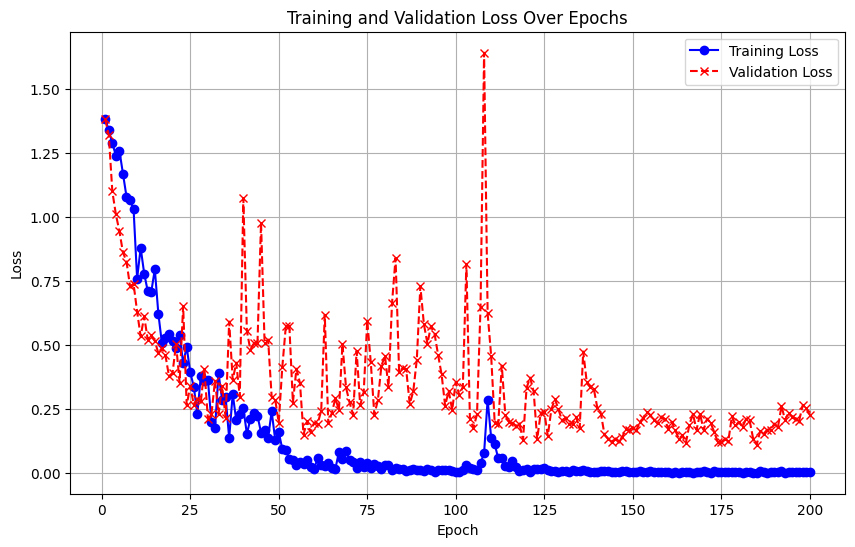

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

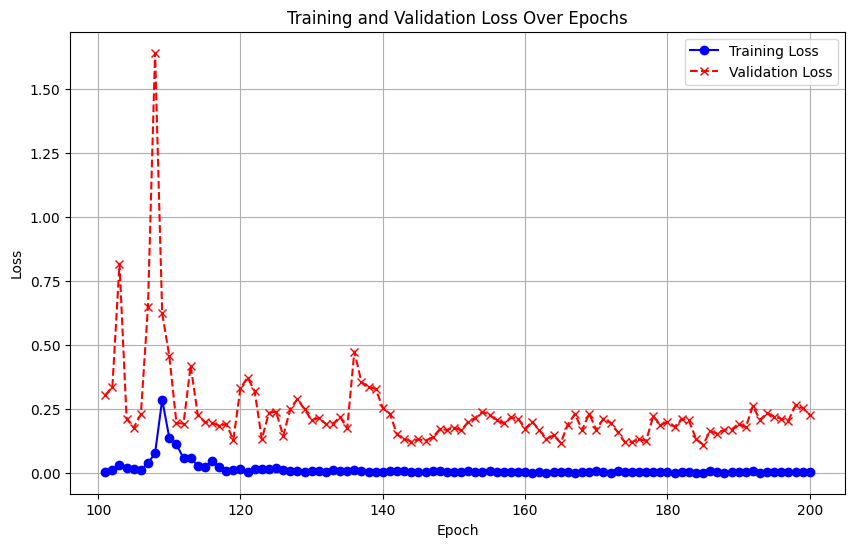

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1)[100:], training_losses[100:], marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(range(1, num_epochs + 1)[100:], validation_losses[100:], marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Experiment 2:
lr=0.0001 ADAM lr_scheduler.OneCycleLR

In [ ]:
path_to_save = '/content'

# Initialize the model
model = ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=4)  # Assuming 4 classes

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002, steps_per_epoch=16, epochs=200)
lrs = []

criterion = nn.CrossEntropyLoss()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_losses = []
validation_losses = []
test_losses=[]

# Training loop
num_epochs = 200  # Adjust the number of epochs as needed
min_val_loss=np.inf
best_val_epoch_num=0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for i, batch in enumerate(tqdm(train_loader)):
        inputs, labels = batch['input'].to(device), batch['label'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

        # Print statistics
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)

    # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['input'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    validation_loss = running_val_loss / len(val_loader)
    validation_losses.append(validation_loss)

    test_correct = 0
    test_total = 0
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch['input'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    test_loss = running_test_loss / len(test_loader)
    test_losses.append(test_loss)

    # Print training loss for the epoch
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {running_val_loss / len(val_loader):.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], test Loss: {running_test_loss / len(test_loader):.4f}")


    print(f"Validation Accuracy for Epoch [{epoch + 1}/{num_epochs}]: {100 * correct / total:.2f}%")
    print(f"Test Accuracy for Epoch [{epoch + 1}/{num_epochs}]: {100 * test_correct / test_total:.2f}%")

    if validation_loss<min_val_loss:
      min_val_loss=validation_loss
      best_val_epoch_num=epoch + 1
      with open(f'{path_to_save}/resnet3d_best.pkl', 'wb') as f:
          pickle.dump(model, f)
      print('best model saved to: ',f'{path_to_save}/resnet3d_best.pkl')


print("-----------------------------------------------------------------")
print("Training finished.")
print(f"Best Val epoch number: {best_val_epoch_num}")

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/200], Training Loss: 1.4422
Epoch [1/200], Validation Loss: 1.3167
Epoch [1/200], test Loss: 1.3384
Validation Accuracy for Epoch [1/200]: 50.00%
Test Accuracy for Epoch [1/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2/200], Training Loss: 1.3249
Epoch [2/200], Validation Loss: 1.0630
Epoch [2/200], test Loss: 1.1609
Validation Accuracy for Epoch [2/200]: 50.00%
Test Accuracy for Epoch [2/200]: 25.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3/200], Training Loss: 1.2917
Epoch [3/200], Validation Loss: 0.8658
Epoch [3/200], test Loss: 1.0012
Validation Accuracy for Epoch [3/200]: 75.00%
Test Accuracy for Epoch [3/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4/200], Training Loss: 1.1651
Epoch [4/200], Validation Loss: 0.7157
Epoch [4/200], test Loss: 1.1574
Validation Accuracy for Epoch [4/200]: 50.00%
Test Accuracy for Epoch [4/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5/200], Training Loss: 1.1072
Epoch [5/200], Validation Loss: 1.4828
Epoch [5/200], test Loss: 2.6868
Validation Accuracy for Epoch [5/200]: 50.00%
Test Accuracy for Epoch [5/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6/200], Training Loss: 1.0783
Epoch [6/200], Validation Loss: 3.4519
Epoch [6/200], test Loss: 5.7482
Validation Accuracy for Epoch [6/200]: 50.00%
Test Accuracy for Epoch [6/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7/200], Training Loss: 1.0943
Epoch [7/200], Validation Loss: 2.5781
Epoch [7/200], test Loss: 4.5323
Validation Accuracy for Epoch [7/200]: 50.00%
Test Accuracy for Epoch [7/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8/200], Training Loss: 0.9211
Epoch [8/200], Validation Loss: 1.0343
Epoch [8/200], test Loss: 1.3935
Validation Accuracy for Epoch [8/200]: 50.00%
Test Accuracy for Epoch [8/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9/200], Training Loss: 0.9419
Epoch [9/200], Validation Loss: 1.7901
Epoch [9/200], test Loss: 1.4375
Validation Accuracy for Epoch [9/200]: 75.00%
Test Accuracy for Epoch [9/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10/200], Training Loss: 1.1640
Epoch [10/200], Validation Loss: 1.8502
Epoch [10/200], test Loss: 1.3194
Validation Accuracy for Epoch [10/200]: 50.00%
Test Accuracy for Epoch [10/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11/200], Training Loss: 1.1433
Epoch [11/200], Validation Loss: 1.2539
Epoch [11/200], test Loss: 1.0900
Validation Accuracy for Epoch [11/200]: 50.00%
Test Accuracy for Epoch [11/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12/200], Training Loss: 0.9289
Epoch [12/200], Validation Loss: 1.8423
Epoch [12/200], test Loss: 1.1617
Validation Accuracy for Epoch [12/200]: 50.00%
Test Accuracy for Epoch [12/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13/200], Training Loss: 1.0763
Epoch [13/200], Validation Loss: 2.4509
Epoch [13/200], test Loss: 2.3615
Validation Accuracy for Epoch [13/200]: 25.00%
Test Accuracy for Epoch [13/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14/200], Training Loss: 0.9135
Epoch [14/200], Validation Loss: 2.7879
Epoch [14/200], test Loss: 1.6891
Validation Accuracy for Epoch [14/200]: 50.00%
Test Accuracy for Epoch [14/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15/200], Training Loss: 0.7456
Epoch [15/200], Validation Loss: 2.7509
Epoch [15/200], test Loss: 3.1297
Validation Accuracy for Epoch [15/200]: 50.00%
Test Accuracy for Epoch [15/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16/200], Training Loss: 0.9460
Epoch [16/200], Validation Loss: 2.2466
Epoch [16/200], test Loss: 2.0315
Validation Accuracy for Epoch [16/200]: 50.00%
Test Accuracy for Epoch [16/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17/200], Training Loss: 1.2194
Epoch [17/200], Validation Loss: 3.4791
Epoch [17/200], test Loss: 4.3052
Validation Accuracy for Epoch [17/200]: 25.00%
Test Accuracy for Epoch [17/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18/200], Training Loss: 0.9766
Epoch [18/200], Validation Loss: 1.4513
Epoch [18/200], test Loss: 1.1010
Validation Accuracy for Epoch [18/200]: 25.00%
Test Accuracy for Epoch [18/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19/200], Training Loss: 1.0085
Epoch [19/200], Validation Loss: 3.1756
Epoch [19/200], test Loss: 0.9793
Validation Accuracy for Epoch [19/200]: 50.00%
Test Accuracy for Epoch [19/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20/200], Training Loss: 0.8617
Epoch [20/200], Validation Loss: 1.1879
Epoch [20/200], test Loss: 1.6822
Validation Accuracy for Epoch [20/200]: 25.00%
Test Accuracy for Epoch [20/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21/200], Training Loss: 0.9119
Epoch [21/200], Validation Loss: 4.5773
Epoch [21/200], test Loss: 2.3579
Validation Accuracy for Epoch [21/200]: 25.00%
Test Accuracy for Epoch [21/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22/200], Training Loss: 0.8291
Epoch [22/200], Validation Loss: 1.9132
Epoch [22/200], test Loss: 1.3383
Validation Accuracy for Epoch [22/200]: 75.00%
Test Accuracy for Epoch [22/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23/200], Training Loss: 0.8130
Epoch [23/200], Validation Loss: 1.5249
Epoch [23/200], test Loss: 2.2064
Validation Accuracy for Epoch [23/200]: 75.00%
Test Accuracy for Epoch [23/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24/200], Training Loss: 0.9733
Epoch [24/200], Validation Loss: 1.7253
Epoch [24/200], test Loss: 1.2515
Validation Accuracy for Epoch [24/200]: 50.00%
Test Accuracy for Epoch [24/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25/200], Training Loss: 0.9611
Epoch [25/200], Validation Loss: 2.6504
Epoch [25/200], test Loss: 0.6439
Validation Accuracy for Epoch [25/200]: 50.00%
Test Accuracy for Epoch [25/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26/200], Training Loss: 1.0229
Epoch [26/200], Validation Loss: 1.5779
Epoch [26/200], test Loss: 1.3139
Validation Accuracy for Epoch [26/200]: 25.00%
Test Accuracy for Epoch [26/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27/200], Training Loss: 1.5575
Epoch [27/200], Validation Loss: 1.3905
Epoch [27/200], test Loss: 1.4022
Validation Accuracy for Epoch [27/200]: 25.00%
Test Accuracy for Epoch [27/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28/200], Training Loss: 1.3902
Epoch [28/200], Validation Loss: 1.1580
Epoch [28/200], test Loss: 1.2686
Validation Accuracy for Epoch [28/200]: 50.00%
Test Accuracy for Epoch [28/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29/200], Training Loss: 1.3941
Epoch [29/200], Validation Loss: 1.0884
Epoch [29/200], test Loss: 1.1777
Validation Accuracy for Epoch [29/200]: 50.00%
Test Accuracy for Epoch [29/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [30/200], Training Loss: 1.3927
Epoch [30/200], Validation Loss: 1.4404
Epoch [30/200], test Loss: 2.0002
Validation Accuracy for Epoch [30/200]: 25.00%
Test Accuracy for Epoch [30/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [31/200], Training Loss: 1.2988
Epoch [31/200], Validation Loss: 1.3183
Epoch [31/200], test Loss: 1.7604
Validation Accuracy for Epoch [31/200]: 25.00%
Test Accuracy for Epoch [31/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [32/200], Training Loss: 1.1553
Epoch [32/200], Validation Loss: 0.8309
Epoch [32/200], test Loss: 1.1646
Validation Accuracy for Epoch [32/200]: 75.00%
Test Accuracy for Epoch [32/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [33/200], Training Loss: 1.1584
Epoch [33/200], Validation Loss: 1.3486
Epoch [33/200], test Loss: 1.6035
Validation Accuracy for Epoch [33/200]: 25.00%
Test Accuracy for Epoch [33/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [34/200], Training Loss: 1.1464
Epoch [34/200], Validation Loss: 0.8294
Epoch [34/200], test Loss: 0.9169
Validation Accuracy for Epoch [34/200]: 50.00%
Test Accuracy for Epoch [34/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [35/200], Training Loss: 0.9785
Epoch [35/200], Validation Loss: 0.5164
Epoch [35/200], test Loss: 1.1420
Validation Accuracy for Epoch [35/200]: 75.00%
Test Accuracy for Epoch [35/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [36/200], Training Loss: 0.8230
Epoch [36/200], Validation Loss: 0.5205
Epoch [36/200], test Loss: 1.2881
Validation Accuracy for Epoch [36/200]: 50.00%
Test Accuracy for Epoch [36/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [37/200], Training Loss: 0.9021
Epoch [37/200], Validation Loss: 0.7656
Epoch [37/200], test Loss: 1.3142
Validation Accuracy for Epoch [37/200]: 50.00%
Test Accuracy for Epoch [37/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [38/200], Training Loss: 1.0269
Epoch [38/200], Validation Loss: 1.2545
Epoch [38/200], test Loss: 2.2769
Validation Accuracy for Epoch [38/200]: 50.00%
Test Accuracy for Epoch [38/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [39/200], Training Loss: 1.0459
Epoch [39/200], Validation Loss: 0.6588
Epoch [39/200], test Loss: 0.8416
Validation Accuracy for Epoch [39/200]: 75.00%
Test Accuracy for Epoch [39/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [40/200], Training Loss: 0.9357
Epoch [40/200], Validation Loss: 1.3127
Epoch [40/200], test Loss: 1.9328
Validation Accuracy for Epoch [40/200]: 50.00%
Test Accuracy for Epoch [40/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [41/200], Training Loss: 0.9497
Epoch [41/200], Validation Loss: 0.7269
Epoch [41/200], test Loss: 0.8954
Validation Accuracy for Epoch [41/200]: 75.00%
Test Accuracy for Epoch [41/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [42/200], Training Loss: 0.8295
Epoch [42/200], Validation Loss: 0.7494
Epoch [42/200], test Loss: 1.2542
Validation Accuracy for Epoch [42/200]: 75.00%
Test Accuracy for Epoch [42/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [43/200], Training Loss: 0.9102
Epoch [43/200], Validation Loss: 0.7761
Epoch [43/200], test Loss: 0.8354
Validation Accuracy for Epoch [43/200]: 50.00%
Test Accuracy for Epoch [43/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [44/200], Training Loss: 0.8220
Epoch [44/200], Validation Loss: 0.6931
Epoch [44/200], test Loss: 0.8278
Validation Accuracy for Epoch [44/200]: 75.00%
Test Accuracy for Epoch [44/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [45/200], Training Loss: 0.7879
Epoch [45/200], Validation Loss: 0.5669
Epoch [45/200], test Loss: 0.8055
Validation Accuracy for Epoch [45/200]: 75.00%
Test Accuracy for Epoch [45/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [46/200], Training Loss: 0.9002
Epoch [46/200], Validation Loss: 0.6231
Epoch [46/200], test Loss: 0.8344
Validation Accuracy for Epoch [46/200]: 75.00%
Test Accuracy for Epoch [46/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [47/200], Training Loss: 0.9917
Epoch [47/200], Validation Loss: 0.8000
Epoch [47/200], test Loss: 0.9261
Validation Accuracy for Epoch [47/200]: 75.00%
Test Accuracy for Epoch [47/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [48/200], Training Loss: 0.8219
Epoch [48/200], Validation Loss: 0.5735
Epoch [48/200], test Loss: 1.0288
Validation Accuracy for Epoch [48/200]: 75.00%
Test Accuracy for Epoch [48/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [49/200], Training Loss: 0.8158
Epoch [49/200], Validation Loss: 0.6918
Epoch [49/200], test Loss: 0.8881
Validation Accuracy for Epoch [49/200]: 50.00%
Test Accuracy for Epoch [49/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [50/200], Training Loss: 1.1865
Epoch [50/200], Validation Loss: 1.0028
Epoch [50/200], test Loss: 1.5588
Validation Accuracy for Epoch [50/200]: 25.00%
Test Accuracy for Epoch [50/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [51/200], Training Loss: 0.7957
Epoch [51/200], Validation Loss: 0.5838
Epoch [51/200], test Loss: 0.9000
Validation Accuracy for Epoch [51/200]: 75.00%
Test Accuracy for Epoch [51/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [52/200], Training Loss: 0.7193
Epoch [52/200], Validation Loss: 1.2448
Epoch [52/200], test Loss: 2.1515
Validation Accuracy for Epoch [52/200]: 50.00%
Test Accuracy for Epoch [52/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [53/200], Training Loss: 0.8001
Epoch [53/200], Validation Loss: 0.8048
Epoch [53/200], test Loss: 0.9049
Validation Accuracy for Epoch [53/200]: 75.00%
Test Accuracy for Epoch [53/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [54/200], Training Loss: 0.7651
Epoch [54/200], Validation Loss: 1.4303
Epoch [54/200], test Loss: 1.2438
Validation Accuracy for Epoch [54/200]: 50.00%
Test Accuracy for Epoch [54/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [55/200], Training Loss: 0.8912
Epoch [55/200], Validation Loss: 1.2650
Epoch [55/200], test Loss: 0.8594
Validation Accuracy for Epoch [55/200]: 25.00%
Test Accuracy for Epoch [55/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [56/200], Training Loss: 0.8491
Epoch [56/200], Validation Loss: 3.2888
Epoch [56/200], test Loss: 0.8678
Validation Accuracy for Epoch [56/200]: 75.00%
Test Accuracy for Epoch [56/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [57/200], Training Loss: 0.8157
Epoch [57/200], Validation Loss: 2.8001
Epoch [57/200], test Loss: 0.8246
Validation Accuracy for Epoch [57/200]: 50.00%
Test Accuracy for Epoch [57/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [58/200], Training Loss: 0.7789
Epoch [58/200], Validation Loss: 2.2823
Epoch [58/200], test Loss: 0.8602
Validation Accuracy for Epoch [58/200]: 50.00%
Test Accuracy for Epoch [58/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [59/200], Training Loss: 0.7186
Epoch [59/200], Validation Loss: 1.4436
Epoch [59/200], test Loss: 0.9800
Validation Accuracy for Epoch [59/200]: 50.00%
Test Accuracy for Epoch [59/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [60/200], Training Loss: 0.7832
Epoch [60/200], Validation Loss: 2.5078
Epoch [60/200], test Loss: 0.8832
Validation Accuracy for Epoch [60/200]: 75.00%
Test Accuracy for Epoch [60/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [61/200], Training Loss: 0.7290
Epoch [61/200], Validation Loss: 0.9111
Epoch [61/200], test Loss: 0.7664
Validation Accuracy for Epoch [61/200]: 75.00%
Test Accuracy for Epoch [61/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [62/200], Training Loss: 1.2152
Epoch [62/200], Validation Loss: 5.1279
Epoch [62/200], test Loss: 8.4407
Validation Accuracy for Epoch [62/200]: 25.00%
Test Accuracy for Epoch [62/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [63/200], Training Loss: 1.3791
Epoch [63/200], Validation Loss: 0.6215
Epoch [63/200], test Loss: 1.3704
Validation Accuracy for Epoch [63/200]: 75.00%
Test Accuracy for Epoch [63/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [64/200], Training Loss: 1.1567
Epoch [64/200], Validation Loss: 0.8903
Epoch [64/200], test Loss: 2.3962
Validation Accuracy for Epoch [64/200]: 50.00%
Test Accuracy for Epoch [64/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [65/200], Training Loss: 1.1939
Epoch [65/200], Validation Loss: 1.2917
Epoch [65/200], test Loss: 1.2421
Validation Accuracy for Epoch [65/200]: 50.00%
Test Accuracy for Epoch [65/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [66/200], Training Loss: 1.1594
Epoch [66/200], Validation Loss: 0.7587
Epoch [66/200], test Loss: 1.1493
Validation Accuracy for Epoch [66/200]: 50.00%
Test Accuracy for Epoch [66/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [67/200], Training Loss: 1.0707
Epoch [67/200], Validation Loss: 0.5739
Epoch [67/200], test Loss: 1.1384
Validation Accuracy for Epoch [67/200]: 75.00%
Test Accuracy for Epoch [67/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [68/200], Training Loss: 0.8261
Epoch [68/200], Validation Loss: 0.4714
Epoch [68/200], test Loss: 1.8166
Validation Accuracy for Epoch [68/200]: 75.00%
Test Accuracy for Epoch [68/200]: 25.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [69/200], Training Loss: 0.7985
Epoch [69/200], Validation Loss: 0.4675
Epoch [69/200], test Loss: 1.8981
Validation Accuracy for Epoch [69/200]: 75.00%
Test Accuracy for Epoch [69/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [70/200], Training Loss: 1.0120
Epoch [70/200], Validation Loss: 0.4984
Epoch [70/200], test Loss: 1.3444
Validation Accuracy for Epoch [70/200]: 75.00%
Test Accuracy for Epoch [70/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [71/200], Training Loss: 0.8808
Epoch [71/200], Validation Loss: 0.6658
Epoch [71/200], test Loss: 1.7130
Validation Accuracy for Epoch [71/200]: 75.00%
Test Accuracy for Epoch [71/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [72/200], Training Loss: 0.7061
Epoch [72/200], Validation Loss: 0.4244
Epoch [72/200], test Loss: 1.9034
Validation Accuracy for Epoch [72/200]: 75.00%
Test Accuracy for Epoch [72/200]: 25.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [73/200], Training Loss: 0.9616
Epoch [73/200], Validation Loss: 0.5244
Epoch [73/200], test Loss: 1.6648
Validation Accuracy for Epoch [73/200]: 75.00%
Test Accuracy for Epoch [73/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [74/200], Training Loss: 0.7297
Epoch [74/200], Validation Loss: 0.5985
Epoch [74/200], test Loss: 1.7387
Validation Accuracy for Epoch [74/200]: 50.00%
Test Accuracy for Epoch [74/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [75/200], Training Loss: 1.0006
Epoch [75/200], Validation Loss: 0.4151
Epoch [75/200], test Loss: 1.1542
Validation Accuracy for Epoch [75/200]: 75.00%
Test Accuracy for Epoch [75/200]: 25.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [76/200], Training Loss: 1.2357
Epoch [76/200], Validation Loss: 1.4030
Epoch [76/200], test Loss: 2.6065
Validation Accuracy for Epoch [76/200]: 50.00%
Test Accuracy for Epoch [76/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [77/200], Training Loss: 0.9801
Epoch [77/200], Validation Loss: 0.7870
Epoch [77/200], test Loss: 2.1643
Validation Accuracy for Epoch [77/200]: 75.00%
Test Accuracy for Epoch [77/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [78/200], Training Loss: 1.1814
Epoch [78/200], Validation Loss: 0.6505
Epoch [78/200], test Loss: 1.1271
Validation Accuracy for Epoch [78/200]: 75.00%
Test Accuracy for Epoch [78/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [79/200], Training Loss: 0.7711
Epoch [79/200], Validation Loss: 0.4316
Epoch [79/200], test Loss: 1.4908
Validation Accuracy for Epoch [79/200]: 75.00%
Test Accuracy for Epoch [79/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [80/200], Training Loss: 1.5158
Epoch [80/200], Validation Loss: 0.5957
Epoch [80/200], test Loss: 1.6733
Validation Accuracy for Epoch [80/200]: 75.00%
Test Accuracy for Epoch [80/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [81/200], Training Loss: 1.2508
Epoch [81/200], Validation Loss: 0.7817
Epoch [81/200], test Loss: 1.5668
Validation Accuracy for Epoch [81/200]: 50.00%
Test Accuracy for Epoch [81/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [82/200], Training Loss: 1.1685
Epoch [82/200], Validation Loss: 0.5743
Epoch [82/200], test Loss: 1.2590
Validation Accuracy for Epoch [82/200]: 75.00%
Test Accuracy for Epoch [82/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [83/200], Training Loss: 0.9420
Epoch [83/200], Validation Loss: 0.4622
Epoch [83/200], test Loss: 1.7194
Validation Accuracy for Epoch [83/200]: 75.00%
Test Accuracy for Epoch [83/200]: 0.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [84/200], Training Loss: 0.8886
Epoch [84/200], Validation Loss: 0.5781
Epoch [84/200], test Loss: 1.4666
Validation Accuracy for Epoch [84/200]: 75.00%
Test Accuracy for Epoch [84/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [85/200], Training Loss: 0.8965
Epoch [85/200], Validation Loss: 0.4787
Epoch [85/200], test Loss: 1.8267
Validation Accuracy for Epoch [85/200]: 75.00%
Test Accuracy for Epoch [85/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [86/200], Training Loss: 0.8544
Epoch [86/200], Validation Loss: 0.5806
Epoch [86/200], test Loss: 0.9305
Validation Accuracy for Epoch [86/200]: 50.00%
Test Accuracy for Epoch [86/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [87/200], Training Loss: 0.7715
Epoch [87/200], Validation Loss: 0.7258
Epoch [87/200], test Loss: 0.9295
Validation Accuracy for Epoch [87/200]: 50.00%
Test Accuracy for Epoch [87/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [88/200], Training Loss: 0.7377
Epoch [88/200], Validation Loss: 0.4885
Epoch [88/200], test Loss: 1.3966
Validation Accuracy for Epoch [88/200]: 75.00%
Test Accuracy for Epoch [88/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [89/200], Training Loss: 0.7776
Epoch [89/200], Validation Loss: 1.0224
Epoch [89/200], test Loss: 2.7501
Validation Accuracy for Epoch [89/200]: 50.00%
Test Accuracy for Epoch [89/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [90/200], Training Loss: 1.1445
Epoch [90/200], Validation Loss: 1.1313
Epoch [90/200], test Loss: 1.6924
Validation Accuracy for Epoch [90/200]: 50.00%
Test Accuracy for Epoch [90/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [91/200], Training Loss: 1.3148
Epoch [91/200], Validation Loss: 0.5833
Epoch [91/200], test Loss: 1.0637
Validation Accuracy for Epoch [91/200]: 75.00%
Test Accuracy for Epoch [91/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [92/200], Training Loss: 0.9485
Epoch [92/200], Validation Loss: 0.4727
Epoch [92/200], test Loss: 0.9495
Validation Accuracy for Epoch [92/200]: 75.00%
Test Accuracy for Epoch [92/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [93/200], Training Loss: 0.9499
Epoch [93/200], Validation Loss: 0.4078
Epoch [93/200], test Loss: 0.8959
Validation Accuracy for Epoch [93/200]: 75.00%
Test Accuracy for Epoch [93/200]: 75.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [94/200], Training Loss: 0.8529
Epoch [94/200], Validation Loss: 0.4590
Epoch [94/200], test Loss: 1.9981
Validation Accuracy for Epoch [94/200]: 75.00%
Test Accuracy for Epoch [94/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [95/200], Training Loss: 1.2298
Epoch [95/200], Validation Loss: 0.5316
Epoch [95/200], test Loss: 1.0242
Validation Accuracy for Epoch [95/200]: 75.00%
Test Accuracy for Epoch [95/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [96/200], Training Loss: 0.8043
Epoch [96/200], Validation Loss: 0.5290
Epoch [96/200], test Loss: 1.2680
Validation Accuracy for Epoch [96/200]: 75.00%
Test Accuracy for Epoch [96/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [97/200], Training Loss: 0.8519
Epoch [97/200], Validation Loss: 0.7747
Epoch [97/200], test Loss: 1.6099
Validation Accuracy for Epoch [97/200]: 50.00%
Test Accuracy for Epoch [97/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [98/200], Training Loss: 0.9910
Epoch [98/200], Validation Loss: 0.6719
Epoch [98/200], test Loss: 1.3777
Validation Accuracy for Epoch [98/200]: 75.00%
Test Accuracy for Epoch [98/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [99/200], Training Loss: 0.8029
Epoch [99/200], Validation Loss: 0.4665
Epoch [99/200], test Loss: 0.8552
Validation Accuracy for Epoch [99/200]: 75.00%
Test Accuracy for Epoch [99/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [100/200], Training Loss: 0.7705
Epoch [100/200], Validation Loss: 0.4128
Epoch [100/200], test Loss: 1.5113
Validation Accuracy for Epoch [100/200]: 75.00%
Test Accuracy for Epoch [100/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [101/200], Training Loss: 0.7473
Epoch [101/200], Validation Loss: 0.5451
Epoch [101/200], test Loss: 1.6476
Validation Accuracy for Epoch [101/200]: 75.00%
Test Accuracy for Epoch [101/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [102/200], Training Loss: 0.5726
Epoch [102/200], Validation Loss: 0.4087
Epoch [102/200], test Loss: 1.1695
Validation Accuracy for Epoch [102/200]: 75.00%
Test Accuracy for Epoch [102/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [103/200], Training Loss: 0.7643
Epoch [103/200], Validation Loss: 0.5687
Epoch [103/200], test Loss: 1.6392
Validation Accuracy for Epoch [103/200]: 75.00%
Test Accuracy for Epoch [103/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [104/200], Training Loss: 0.6602
Epoch [104/200], Validation Loss: 0.3812
Epoch [104/200], test Loss: 1.2807
Validation Accuracy for Epoch [104/200]: 75.00%
Test Accuracy for Epoch [104/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [105/200], Training Loss: 0.7087
Epoch [105/200], Validation Loss: 0.4306
Epoch [105/200], test Loss: 1.3504
Validation Accuracy for Epoch [105/200]: 100.00%
Test Accuracy for Epoch [105/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [106/200], Training Loss: 0.5984
Epoch [106/200], Validation Loss: 0.3840
Epoch [106/200], test Loss: 1.6058
Validation Accuracy for Epoch [106/200]: 75.00%
Test Accuracy for Epoch [106/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [107/200], Training Loss: 0.7987
Epoch [107/200], Validation Loss: 0.4018
Epoch [107/200], test Loss: 1.0048
Validation Accuracy for Epoch [107/200]: 75.00%
Test Accuracy for Epoch [107/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [108/200], Training Loss: 0.7806
Epoch [108/200], Validation Loss: 0.7769
Epoch [108/200], test Loss: 1.6283
Validation Accuracy for Epoch [108/200]: 50.00%
Test Accuracy for Epoch [108/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [109/200], Training Loss: 0.8634
Epoch [109/200], Validation Loss: 0.4986
Epoch [109/200], test Loss: 0.9486
Validation Accuracy for Epoch [109/200]: 75.00%
Test Accuracy for Epoch [109/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [110/200], Training Loss: 0.7878
Epoch [110/200], Validation Loss: 0.4763
Epoch [110/200], test Loss: 0.9442
Validation Accuracy for Epoch [110/200]: 75.00%
Test Accuracy for Epoch [110/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [111/200], Training Loss: 0.6873
Epoch [111/200], Validation Loss: 0.4551
Epoch [111/200], test Loss: 0.9649
Validation Accuracy for Epoch [111/200]: 75.00%
Test Accuracy for Epoch [111/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [112/200], Training Loss: 0.7091
Epoch [112/200], Validation Loss: 0.6537
Epoch [112/200], test Loss: 1.8704
Validation Accuracy for Epoch [112/200]: 50.00%
Test Accuracy for Epoch [112/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [113/200], Training Loss: 0.7237
Epoch [113/200], Validation Loss: 0.9068
Epoch [113/200], test Loss: 1.9520
Validation Accuracy for Epoch [113/200]: 50.00%
Test Accuracy for Epoch [113/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [114/200], Training Loss: 0.7558
Epoch [114/200], Validation Loss: 0.7390
Epoch [114/200], test Loss: 1.2232
Validation Accuracy for Epoch [114/200]: 50.00%
Test Accuracy for Epoch [114/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [115/200], Training Loss: 0.7167
Epoch [115/200], Validation Loss: 0.4343
Epoch [115/200], test Loss: 0.8798
Validation Accuracy for Epoch [115/200]: 75.00%
Test Accuracy for Epoch [115/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [116/200], Training Loss: 0.7161
Epoch [116/200], Validation Loss: 0.6307
Epoch [116/200], test Loss: 1.5318
Validation Accuracy for Epoch [116/200]: 75.00%
Test Accuracy for Epoch [116/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [117/200], Training Loss: 0.7889
Epoch [117/200], Validation Loss: 0.3935
Epoch [117/200], test Loss: 1.5713
Validation Accuracy for Epoch [117/200]: 100.00%
Test Accuracy for Epoch [117/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [118/200], Training Loss: 0.6493
Epoch [118/200], Validation Loss: 0.3499
Epoch [118/200], test Loss: 1.0230
Validation Accuracy for Epoch [118/200]: 100.00%
Test Accuracy for Epoch [118/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [119/200], Training Loss: 0.7442
Epoch [119/200], Validation Loss: 0.4696
Epoch [119/200], test Loss: 1.5103
Validation Accuracy for Epoch [119/200]: 75.00%
Test Accuracy for Epoch [119/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [120/200], Training Loss: 0.6258
Epoch [120/200], Validation Loss: 1.0966
Epoch [120/200], test Loss: 1.9215
Validation Accuracy for Epoch [120/200]: 75.00%
Test Accuracy for Epoch [120/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [121/200], Training Loss: 0.7166
Epoch [121/200], Validation Loss: 0.3614
Epoch [121/200], test Loss: 0.9807
Validation Accuracy for Epoch [121/200]: 75.00%
Test Accuracy for Epoch [121/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [122/200], Training Loss: 0.7714
Epoch [122/200], Validation Loss: 0.3135
Epoch [122/200], test Loss: 1.4229
Validation Accuracy for Epoch [122/200]: 100.00%
Test Accuracy for Epoch [122/200]: 50.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [123/200], Training Loss: 0.6965
Epoch [123/200], Validation Loss: 0.3733
Epoch [123/200], test Loss: 0.8303
Validation Accuracy for Epoch [123/200]: 75.00%
Test Accuracy for Epoch [123/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [124/200], Training Loss: 0.7716
Epoch [124/200], Validation Loss: 1.1435
Epoch [124/200], test Loss: 2.8390
Validation Accuracy for Epoch [124/200]: 50.00%
Test Accuracy for Epoch [124/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [125/200], Training Loss: 0.6280
Epoch [125/200], Validation Loss: 0.4356
Epoch [125/200], test Loss: 1.3324
Validation Accuracy for Epoch [125/200]: 75.00%
Test Accuracy for Epoch [125/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [126/200], Training Loss: 0.8329
Epoch [126/200], Validation Loss: 0.4286
Epoch [126/200], test Loss: 1.1154
Validation Accuracy for Epoch [126/200]: 75.00%
Test Accuracy for Epoch [126/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [127/200], Training Loss: 0.7113
Epoch [127/200], Validation Loss: 0.4120
Epoch [127/200], test Loss: 0.9663
Validation Accuracy for Epoch [127/200]: 75.00%
Test Accuracy for Epoch [127/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [128/200], Training Loss: 0.6980
Epoch [128/200], Validation Loss: 0.4104
Epoch [128/200], test Loss: 1.8209
Validation Accuracy for Epoch [128/200]: 75.00%
Test Accuracy for Epoch [128/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [129/200], Training Loss: 0.6312
Epoch [129/200], Validation Loss: 0.3956
Epoch [129/200], test Loss: 0.8513
Validation Accuracy for Epoch [129/200]: 75.00%
Test Accuracy for Epoch [129/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [130/200], Training Loss: 0.5859
Epoch [130/200], Validation Loss: 0.3360
Epoch [130/200], test Loss: 1.1724
Validation Accuracy for Epoch [130/200]: 100.00%
Test Accuracy for Epoch [130/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [131/200], Training Loss: 0.6168
Epoch [131/200], Validation Loss: 0.3579
Epoch [131/200], test Loss: 1.2303
Validation Accuracy for Epoch [131/200]: 100.00%
Test Accuracy for Epoch [131/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [132/200], Training Loss: 0.7012
Epoch [132/200], Validation Loss: 1.1896
Epoch [132/200], test Loss: 1.7157
Validation Accuracy for Epoch [132/200]: 50.00%
Test Accuracy for Epoch [132/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [133/200], Training Loss: 0.5097
Epoch [133/200], Validation Loss: 0.2628
Epoch [133/200], test Loss: 0.6969
Validation Accuracy for Epoch [133/200]: 100.00%
Test Accuracy for Epoch [133/200]: 75.00%
best model saved to:  /content/resnet3d_best.pkl


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [134/200], Training Loss: 0.7022
Epoch [134/200], Validation Loss: 2.0719
Epoch [134/200], test Loss: 4.4017
Validation Accuracy for Epoch [134/200]: 50.00%
Test Accuracy for Epoch [134/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [135/200], Training Loss: 0.6191
Epoch [135/200], Validation Loss: 0.4343
Epoch [135/200], test Loss: 1.2285
Validation Accuracy for Epoch [135/200]: 75.00%
Test Accuracy for Epoch [135/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [136/200], Training Loss: 0.4911
Epoch [136/200], Validation Loss: 0.3972
Epoch [136/200], test Loss: 1.6899
Validation Accuracy for Epoch [136/200]: 75.00%
Test Accuracy for Epoch [136/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [137/200], Training Loss: 0.5345
Epoch [137/200], Validation Loss: 0.4673
Epoch [137/200], test Loss: 0.9086
Validation Accuracy for Epoch [137/200]: 75.00%
Test Accuracy for Epoch [137/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [138/200], Training Loss: 0.6416
Epoch [138/200], Validation Loss: 0.6626
Epoch [138/200], test Loss: 2.0356
Validation Accuracy for Epoch [138/200]: 75.00%
Test Accuracy for Epoch [138/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [139/200], Training Loss: 0.4523
Epoch [139/200], Validation Loss: 0.9988
Epoch [139/200], test Loss: 2.3474
Validation Accuracy for Epoch [139/200]: 75.00%
Test Accuracy for Epoch [139/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [140/200], Training Loss: 0.4576
Epoch [140/200], Validation Loss: 0.4030
Epoch [140/200], test Loss: 0.9711
Validation Accuracy for Epoch [140/200]: 75.00%
Test Accuracy for Epoch [140/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [141/200], Training Loss: 0.6014
Epoch [141/200], Validation Loss: 0.3932
Epoch [141/200], test Loss: 0.9013
Validation Accuracy for Epoch [141/200]: 75.00%
Test Accuracy for Epoch [141/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [142/200], Training Loss: 0.6822
Epoch [142/200], Validation Loss: 0.8377
Epoch [142/200], test Loss: 2.5325
Validation Accuracy for Epoch [142/200]: 75.00%
Test Accuracy for Epoch [142/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [143/200], Training Loss: 0.3721
Epoch [143/200], Validation Loss: 0.5339
Epoch [143/200], test Loss: 1.8285
Validation Accuracy for Epoch [143/200]: 75.00%
Test Accuracy for Epoch [143/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [144/200], Training Loss: 0.4675
Epoch [144/200], Validation Loss: 1.7978
Epoch [144/200], test Loss: 2.2785
Validation Accuracy for Epoch [144/200]: 75.00%
Test Accuracy for Epoch [144/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [145/200], Training Loss: 0.5220
Epoch [145/200], Validation Loss: 2.4221
Epoch [145/200], test Loss: 2.7764
Validation Accuracy for Epoch [145/200]: 75.00%
Test Accuracy for Epoch [145/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [146/200], Training Loss: 0.3934
Epoch [146/200], Validation Loss: 0.6530
Epoch [146/200], test Loss: 1.6104
Validation Accuracy for Epoch [146/200]: 75.00%
Test Accuracy for Epoch [146/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [147/200], Training Loss: 0.7823
Epoch [147/200], Validation Loss: 2.6644
Epoch [147/200], test Loss: 3.8902
Validation Accuracy for Epoch [147/200]: 75.00%
Test Accuracy for Epoch [147/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [148/200], Training Loss: 0.8421
Epoch [148/200], Validation Loss: 0.7232
Epoch [148/200], test Loss: 0.8778
Validation Accuracy for Epoch [148/200]: 50.00%
Test Accuracy for Epoch [148/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [149/200], Training Loss: 0.6661
Epoch [149/200], Validation Loss: 1.4350
Epoch [149/200], test Loss: 2.5859
Validation Accuracy for Epoch [149/200]: 50.00%
Test Accuracy for Epoch [149/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [150/200], Training Loss: 0.5177
Epoch [150/200], Validation Loss: 0.3902
Epoch [150/200], test Loss: 1.7138
Validation Accuracy for Epoch [150/200]: 100.00%
Test Accuracy for Epoch [150/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [151/200], Training Loss: 0.5927
Epoch [151/200], Validation Loss: 0.5818
Epoch [151/200], test Loss: 0.9942
Validation Accuracy for Epoch [151/200]: 75.00%
Test Accuracy for Epoch [151/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [152/200], Training Loss: 0.4457
Epoch [152/200], Validation Loss: 1.3995
Epoch [152/200], test Loss: 2.5559
Validation Accuracy for Epoch [152/200]: 50.00%
Test Accuracy for Epoch [152/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [153/200], Training Loss: 0.5550
Epoch [153/200], Validation Loss: 0.4833
Epoch [153/200], test Loss: 1.9484
Validation Accuracy for Epoch [153/200]: 75.00%
Test Accuracy for Epoch [153/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [154/200], Training Loss: 0.4545
Epoch [154/200], Validation Loss: 0.3585
Epoch [154/200], test Loss: 1.3898
Validation Accuracy for Epoch [154/200]: 75.00%
Test Accuracy for Epoch [154/200]: 25.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [155/200], Training Loss: 0.5212
Epoch [155/200], Validation Loss: 0.3065
Epoch [155/200], test Loss: 0.7813
Validation Accuracy for Epoch [155/200]: 75.00%
Test Accuracy for Epoch [155/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [156/200], Training Loss: 0.4586
Epoch [156/200], Validation Loss: 0.8305
Epoch [156/200], test Loss: 1.4751
Validation Accuracy for Epoch [156/200]: 50.00%
Test Accuracy for Epoch [156/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [157/200], Training Loss: 0.7203
Epoch [157/200], Validation Loss: 0.5599
Epoch [157/200], test Loss: 0.8778
Validation Accuracy for Epoch [157/200]: 75.00%
Test Accuracy for Epoch [157/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [158/200], Training Loss: 0.4045
Epoch [158/200], Validation Loss: 0.4587
Epoch [158/200], test Loss: 1.2953
Validation Accuracy for Epoch [158/200]: 75.00%
Test Accuracy for Epoch [158/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [159/200], Training Loss: 0.3819
Epoch [159/200], Validation Loss: 0.5371
Epoch [159/200], test Loss: 0.8916
Validation Accuracy for Epoch [159/200]: 75.00%
Test Accuracy for Epoch [159/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [160/200], Training Loss: 0.3631
Epoch [160/200], Validation Loss: 0.5281
Epoch [160/200], test Loss: 1.2090
Validation Accuracy for Epoch [160/200]: 75.00%
Test Accuracy for Epoch [160/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [161/200], Training Loss: 0.2774
Epoch [161/200], Validation Loss: 0.6085
Epoch [161/200], test Loss: 0.7171
Validation Accuracy for Epoch [161/200]: 75.00%
Test Accuracy for Epoch [161/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [162/200], Training Loss: 0.5459
Epoch [162/200], Validation Loss: 0.5141
Epoch [162/200], test Loss: 1.5154
Validation Accuracy for Epoch [162/200]: 75.00%
Test Accuracy for Epoch [162/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [163/200], Training Loss: 0.4893
Epoch [163/200], Validation Loss: 1.1712
Epoch [163/200], test Loss: 1.5248
Validation Accuracy for Epoch [163/200]: 75.00%
Test Accuracy for Epoch [163/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [164/200], Training Loss: 0.3303
Epoch [164/200], Validation Loss: 0.3726
Epoch [164/200], test Loss: 0.7851
Validation Accuracy for Epoch [164/200]: 75.00%
Test Accuracy for Epoch [164/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [165/200], Training Loss: 0.3860
Epoch [165/200], Validation Loss: 1.7674
Epoch [165/200], test Loss: 2.1543
Validation Accuracy for Epoch [165/200]: 75.00%
Test Accuracy for Epoch [165/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [166/200], Training Loss: 0.2617
Epoch [166/200], Validation Loss: 1.2512
Epoch [166/200], test Loss: 1.6876
Validation Accuracy for Epoch [166/200]: 75.00%
Test Accuracy for Epoch [166/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [167/200], Training Loss: 0.4131
Epoch [167/200], Validation Loss: 0.5354
Epoch [167/200], test Loss: 0.8753
Validation Accuracy for Epoch [167/200]: 75.00%
Test Accuracy for Epoch [167/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [168/200], Training Loss: 0.2650
Epoch [168/200], Validation Loss: 0.4641
Epoch [168/200], test Loss: 1.0375
Validation Accuracy for Epoch [168/200]: 75.00%
Test Accuracy for Epoch [168/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [169/200], Training Loss: 0.3156
Epoch [169/200], Validation Loss: 1.5342
Epoch [169/200], test Loss: 1.8958
Validation Accuracy for Epoch [169/200]: 75.00%
Test Accuracy for Epoch [169/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [170/200], Training Loss: 0.3053
Epoch [170/200], Validation Loss: 1.2918
Epoch [170/200], test Loss: 1.7658
Validation Accuracy for Epoch [170/200]: 75.00%
Test Accuracy for Epoch [170/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [171/200], Training Loss: 0.3270
Epoch [171/200], Validation Loss: 1.1816
Epoch [171/200], test Loss: 1.4407
Validation Accuracy for Epoch [171/200]: 75.00%
Test Accuracy for Epoch [171/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [172/200], Training Loss: 0.1825
Epoch [172/200], Validation Loss: 1.5851
Epoch [172/200], test Loss: 1.8318
Validation Accuracy for Epoch [172/200]: 75.00%
Test Accuracy for Epoch [172/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [173/200], Training Loss: 0.2409
Epoch [173/200], Validation Loss: 1.7332
Epoch [173/200], test Loss: 1.6819
Validation Accuracy for Epoch [173/200]: 75.00%
Test Accuracy for Epoch [173/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [174/200], Training Loss: 0.3159
Epoch [174/200], Validation Loss: 2.2329
Epoch [174/200], test Loss: 2.1404
Validation Accuracy for Epoch [174/200]: 50.00%
Test Accuracy for Epoch [174/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [175/200], Training Loss: 0.2038
Epoch [175/200], Validation Loss: 1.3752
Epoch [175/200], test Loss: 1.3763
Validation Accuracy for Epoch [175/200]: 75.00%
Test Accuracy for Epoch [175/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [176/200], Training Loss: 0.3977
Epoch [176/200], Validation Loss: 0.7901
Epoch [176/200], test Loss: 1.4416
Validation Accuracy for Epoch [176/200]: 75.00%
Test Accuracy for Epoch [176/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [177/200], Training Loss: 0.1904
Epoch [177/200], Validation Loss: 1.2884
Epoch [177/200], test Loss: 1.5949
Validation Accuracy for Epoch [177/200]: 75.00%
Test Accuracy for Epoch [177/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [178/200], Training Loss: 0.1649
Epoch [178/200], Validation Loss: 1.5743
Epoch [178/200], test Loss: 1.6260
Validation Accuracy for Epoch [178/200]: 75.00%
Test Accuracy for Epoch [178/200]: 75.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [179/200], Training Loss: 0.1904
Epoch [179/200], Validation Loss: 1.5371
Epoch [179/200], test Loss: 1.8123
Validation Accuracy for Epoch [179/200]: 75.00%
Test Accuracy for Epoch [179/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [180/200], Training Loss: 0.1421
Epoch [180/200], Validation Loss: 1.6574
Epoch [180/200], test Loss: 1.9688
Validation Accuracy for Epoch [180/200]: 75.00%
Test Accuracy for Epoch [180/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [181/200], Training Loss: 0.2118
Epoch [181/200], Validation Loss: 1.9399
Epoch [181/200], test Loss: 2.2171
Validation Accuracy for Epoch [181/200]: 75.00%
Test Accuracy for Epoch [181/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [182/200], Training Loss: 0.3121
Epoch [182/200], Validation Loss: 1.3063
Epoch [182/200], test Loss: 1.9943
Validation Accuracy for Epoch [182/200]: 75.00%
Test Accuracy for Epoch [182/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [183/200], Training Loss: 0.2776
Epoch [183/200], Validation Loss: 1.3193
Epoch [183/200], test Loss: 1.8175
Validation Accuracy for Epoch [183/200]: 75.00%
Test Accuracy for Epoch [183/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [184/200], Training Loss: 0.2343
Epoch [184/200], Validation Loss: 1.7157
Epoch [184/200], test Loss: 1.9634
Validation Accuracy for Epoch [184/200]: 75.00%
Test Accuracy for Epoch [184/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [185/200], Training Loss: 0.1935
Epoch [185/200], Validation Loss: 1.7265
Epoch [185/200], test Loss: 2.0853
Validation Accuracy for Epoch [185/200]: 75.00%
Test Accuracy for Epoch [185/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [186/200], Training Loss: 0.2286
Epoch [186/200], Validation Loss: 1.4725
Epoch [186/200], test Loss: 1.7424
Validation Accuracy for Epoch [186/200]: 75.00%
Test Accuracy for Epoch [186/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [187/200], Training Loss: 0.1568
Epoch [187/200], Validation Loss: 1.5144
Epoch [187/200], test Loss: 1.6364
Validation Accuracy for Epoch [187/200]: 75.00%
Test Accuracy for Epoch [187/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [188/200], Training Loss: 0.0934
Epoch [188/200], Validation Loss: 1.5827
Epoch [188/200], test Loss: 1.8999
Validation Accuracy for Epoch [188/200]: 75.00%
Test Accuracy for Epoch [188/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [189/200], Training Loss: 0.2241
Epoch [189/200], Validation Loss: 1.4577
Epoch [189/200], test Loss: 1.6231
Validation Accuracy for Epoch [189/200]: 75.00%
Test Accuracy for Epoch [189/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [190/200], Training Loss: 0.1815
Epoch [190/200], Validation Loss: 1.5693
Epoch [190/200], test Loss: 1.8664
Validation Accuracy for Epoch [190/200]: 75.00%
Test Accuracy for Epoch [190/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [191/200], Training Loss: 0.1186
Epoch [191/200], Validation Loss: 1.4402
Epoch [191/200], test Loss: 1.7699
Validation Accuracy for Epoch [191/200]: 75.00%
Test Accuracy for Epoch [191/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [192/200], Training Loss: 0.2071
Epoch [192/200], Validation Loss: 1.5339
Epoch [192/200], test Loss: 1.9578
Validation Accuracy for Epoch [192/200]: 75.00%
Test Accuracy for Epoch [192/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [193/200], Training Loss: 0.1072
Epoch [193/200], Validation Loss: 1.4701
Epoch [193/200], test Loss: 1.9217
Validation Accuracy for Epoch [193/200]: 75.00%
Test Accuracy for Epoch [193/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [194/200], Training Loss: 0.2547
Epoch [194/200], Validation Loss: 1.7027
Epoch [194/200], test Loss: 2.0681
Validation Accuracy for Epoch [194/200]: 75.00%
Test Accuracy for Epoch [194/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [195/200], Training Loss: 0.2366
Epoch [195/200], Validation Loss: 1.5963
Epoch [195/200], test Loss: 1.8862
Validation Accuracy for Epoch [195/200]: 75.00%
Test Accuracy for Epoch [195/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [196/200], Training Loss: 0.2278
Epoch [196/200], Validation Loss: 1.4343
Epoch [196/200], test Loss: 2.0145
Validation Accuracy for Epoch [196/200]: 75.00%
Test Accuracy for Epoch [196/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [197/200], Training Loss: 0.1631
Epoch [197/200], Validation Loss: 1.5168
Epoch [197/200], test Loss: 1.9096
Validation Accuracy for Epoch [197/200]: 75.00%
Test Accuracy for Epoch [197/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [198/200], Training Loss: 0.1300
Epoch [198/200], Validation Loss: 1.6229
Epoch [198/200], test Loss: 2.1175
Validation Accuracy for Epoch [198/200]: 75.00%
Test Accuracy for Epoch [198/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [199/200], Training Loss: 0.1046
Epoch [199/200], Validation Loss: 1.6648
Epoch [199/200], test Loss: 2.0416
Validation Accuracy for Epoch [199/200]: 75.00%
Test Accuracy for Epoch [199/200]: 50.00%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [200/200], Training Loss: 0.3252
Epoch [200/200], Validation Loss: 1.5964
Epoch [200/200], test Loss: 1.8962
Validation Accuracy for Epoch [200/200]: 75.00%
Test Accuracy for Epoch [200/200]: 50.00%
-----------------------------------------------------------------
Training finished.
Best Val epoch number: 133


In [ ]:
def load_model(model_path):
    """
        Load a model from a specified path using pickle.

        Args:
        - model_path (str): Path to the saved model file.

        Returns:
        - model: Loaded model object.
    """
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

model_path="/content/drive/MyDrive/output/ML_Task/resnet3d_best_0.0001_ADAM_best_on_min_val_loss.pkl"

loaded_model = load_model(model_path)

In [ ]:
loaded_model.eval()  # Set model to evaluation mode
test_correct = 0
test_total = 0
running_test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['input'].to(device), batch['label'].to(device)
        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
test_loss = running_test_loss / len(test_loader)


# Print training loss for the epoch
if (epoch + 1) % 1 == 0:
    print(f"Best model test Loss: {running_test_loss / len(test_loader):.4f}")

print(f"Test Accuracy for best model on val loss: {100 * test_correct / test_total:.2f}%")

Best model test Loss: 0.6969
Test Accuracy for best model on val loss: 75.00%


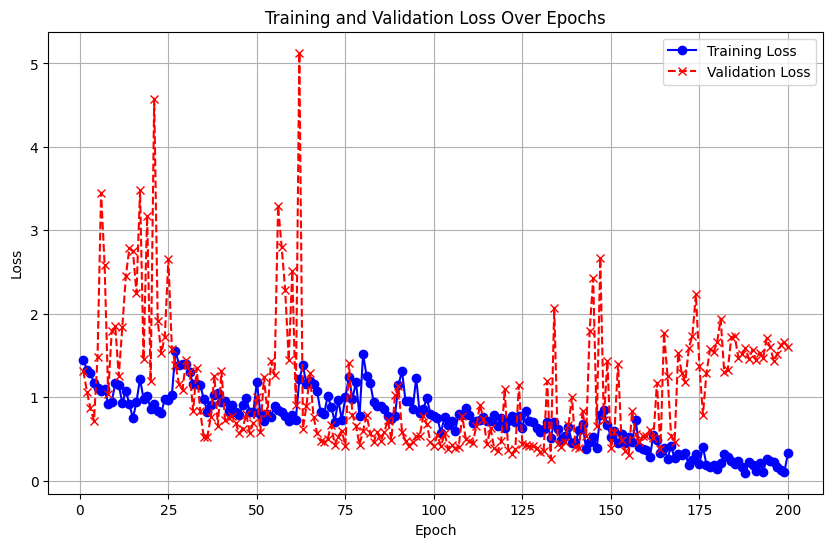

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

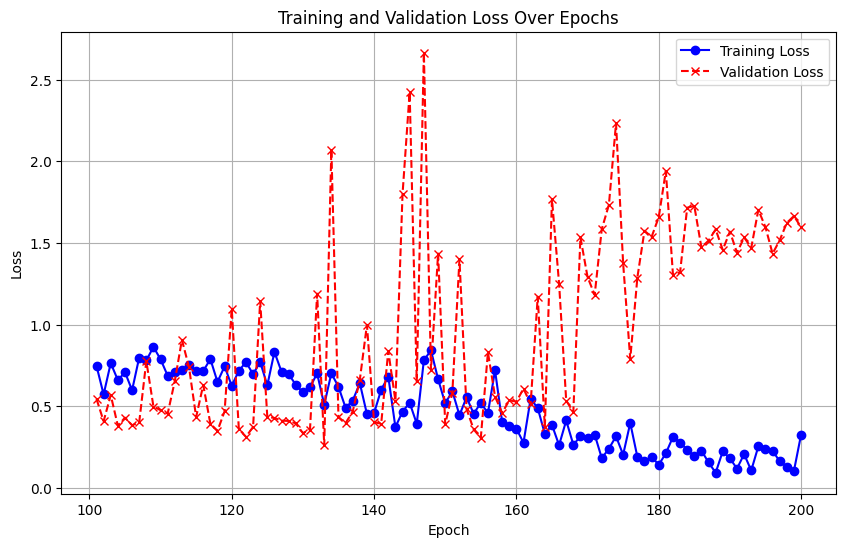

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1)[100:], training_losses[100:], marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(range(1, num_epochs + 1)[100:], validation_losses[100:], marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Predict on test and save to file

#### Load the test data

In [ ]:
# path to train datasets, labels and VoI template files

test_rCBF = Path("/content/drive/MyDrive/Assignment/test_images_rcbf.nii")
test_DAT = Path("/content/drive/MyDrive/Assignment/test_images_sbr.nii")

In [ ]:
# Load NIfTI and extract image data

test_PET_rCBF = nib.load(test_rCBF)
test_data_rCBF = test_PET_rCBF.get_fdata()

test_PET_DAT = nib.load(test_DAT)
test_data_DAT = test_PET_DAT.get_fdata()

#### Dataset creation and normalization

In [ ]:
tdata = create_xdata(test_data_rCBF, test_data_DAT)
print(tdata.shape)

(41, 2, 64, 64, 64)


In [ ]:
test_dataset = CustomDataset(tdata, np.zeros((tdata.shape[0])) , transform=val_transforms)  # Apply validation transformation

print(f"There are {len(test_dataset)} test images")

There are 41 test images


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False)
print('test dataset', np.unique(test_dataset.labels, return_counts=True))

test dataset (array([0.]), array([41]))


#### Load model and make predictions

In [ ]:
def load_model(model_path):
    """
        Load a model from a specified path using pickle.

        Args:
        - model_path (str): Path to the saved model file.

        Returns:
        - model: Loaded model object.
    """
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model


model_path="/content/drive/MyDrive/output/ML_Task/resnet3d_best_0.0002_SGD_best_on_min_val_loss.pkl"

loaded_model = load_model(model_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)


loaded_model.eval()  # Set model to evaluation mode

preds = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['input'].to(device), batch['label'].to(device)
        outputs = loaded_model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        preds.append(predicted.cpu())

print(len(preds))

41


In [ ]:
np_preds = np.array(preds).squeeze()+1
print(np_preds.shape)

(41,)


In [ ]:
print(np_preds)

[3 2 3 1 4 1 3 2 3 2 1 1 2 1 2 4 1 1 1 3 1 3 3 2 3 4 4 1 2 2 1 2 2 1 1 3 3
 1 1 3 3]


#### save to file

In [ ]:
# Save the DataFrame to a CSV file, including patient number

index_array = np.arange(1, np_preds.shape[0] + 1)
combined_array = np.column_stack((index_array, np_preds))

df = pd.DataFrame(combined_array, columns=['patient_number', 'Branch_ResNet_predication'])
df.to_csv("patient_predictions.csv", index=False)
